# Notebook pour comparer le baseline NN et le LNN


Importation des modules nécessaires

In [19]:
import jax
import jax.numpy as jnp
import numpy as np
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt
from functools import partial # reduces arguments to function by making some subset implicit

from jax.example_libraries import stax
from jax.example_libraries import optimizers

# visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from functools import partial
import proglog

#Pour le baseline
import tensorflow as tf
from scipy.integrate import solve_ivp

### Make sure we're using a GPU

In [1]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

cpu


/var/folders/_5/450_dsxx7pqfnwb2rs5wpndm0000gn/T/ipykernel_53049/1991717721.py:2: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  print(xla_bridge.get_backend().platform)


## Fonctions pour obtenir la dynamique exacte du double pendule

Pour cela, on revient au cours de physique et au Lagrangian analytique du double pendule.

In [3]:
def lagrangian(q, q_dot, m1, m2, l1, l2, g):
  t1, t2 = q     # theta 1 and theta 2
  w1, w2 = q_dot # omega 1 and omega 2

  # kinetic energy (T)
  T1 = 0.5 * m1 * (l1 * w1)**2
  T2 = 0.5 * m2 * ((l1 * w1)**2 + (l2 * w2)**2 +
                    2 * l1 * l2 * w1 * w2 * jnp.cos(t1 - t2))
  T = T1 + T2

  # potential energy (V)
  y1 = -l1 * jnp.cos(t1)
  y2 = y1 - l2 * jnp.cos(t2)
  V = m1 * g * y1 + m2 * g * y2

  return T - V

Résultats analytiques du double pendule

\begin{align}
& \alpha_1(\theta_1,\theta_2) ~:=~ \displaystyle\frac{l_2}{l_1}\left(\frac{m_2}{m_1 + m_2}\right)\cos(\theta_1 - \theta_2)\\
&\alpha_2(\theta_1,\theta_2) ~:=~ \frac{l_1}{l_2}\cos(\theta_1-\theta_2)\\
&\displaystyle f_1(\theta_1, \theta_2, \dot{\theta}_1, \dot{\theta}_2) ~:=~
-\frac{l_2}{l_1}\left(\frac{m_2}{m_1+m_2}\right) \dot{\theta}_2^2\sin(\theta_1 - \theta_2)
- \frac{g}{l_1} \sin\theta_1 \\
&\displaystyle f_2(\theta_1, \theta_2, \dot{\theta}_1, \dot{\theta}_2) ~:=~
\frac{l_1}{l_2}\dot{\theta}_1^2\sin(\theta_1-\theta_2) - \frac{g}{l_2} \sin\theta_2 \\
&g_1 := \displaystyle\frac{f_1 - \alpha_1 f_2}{1 - \alpha_1\alpha_2}
\quad\quad
g_2 := \displaystyle\frac{-\alpha_2 f_1 + f_2}{1 - \alpha_1\alpha_2}
\end{align}

Les dynamiques analytiques s'expriment sous la forme :

$$
\displaystyle\frac{d}{dt}
\left( \begin{matrix} \theta_1 \\[1pt] \theta_2 \\[1pt] \omega_1 \\[1pt] \omega_1 \end{matrix} \right)
=
\left( \begin{matrix} \omega_1 \\ \omega_2 \\ g_1(\theta_1,\theta_2,\omega_1,\omega_2)
\\ g_2(\theta_1,\theta_2,\omega_1,\omega_2) \end{matrix} \right)
$$

In [2]:
def f_analytical(state, t=0, m1=1, m2=1, l1=1, l2=1, g=9.8):
  t1, t2, w1, w2 = state
  a1 = (l2 / l1) * (m2 / (m1 + m2)) * jnp.cos(t1 - t2)
  a2 = (l1 / l2) * jnp.cos(t1 - t2)
  f1 = -(l2 / l1) * (m2 / (m1 + m2)) * (w2**2) * jnp.sin(t1 - t2) - \
      (g / l1) * jnp.sin(t1)
  f2 = (l1 / l2) * (w1**2) * jnp.sin(t1 - t2) - (g / l2) * jnp.sin(t2)
  g1 = (f1 - a1 * f2) / (1 - a1 * a2)
  g2 = (f2 - a2 * f1) / (1 - a1 * a2)
  return jnp.stack([w1, w2, g1, g2])

### Génération des dynamiques du double pendule


In [6]:
def equation_of_motion(lagrangian, state, t=None):
  q, q_t = jnp.split(state, 2)
  q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t))
          @ (jax.grad(lagrangian, 0)(q, q_t)
             - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
  return jnp.concatenate([q_t, q_tt])

def solve_lagrangian(lagrangian, initial_state, **kwargs):
  # We currently run odeint on CPUs only, because its cost is dominated by
  # control flow, which is slow on GPUs.
  @partial(jax.jit, backend='cpu')
  def f(initial_state):
    return odeint(partial(equation_of_motion, lagrangian),
                  initial_state, **kwargs)
  return f(initial_state)

### Fonctions d'aide
Fonction importantes pour pouvoir faire les calculs avec Jax

In [7]:
# Double pendulum dynamics via the rewritten Euler-Lagrange
@partial(jax.jit, backend='cpu')
def solve_autograd(initial_state, times, m1=1, m2=1, l1=1, l2=1, g=9.8):
  L = partial(lagrangian, m1=m1, m2=m2, l1=l1, l2=l2, g=g)
  return solve_lagrangian(L, initial_state, t=times, rtol=1e-10, atol=1e-10)

# Double pendulum dynamics via analytical forces taken from Diego's blog
@partial(jax.jit, backend='cpu')
def solve_analytical(initial_state, times):
  return odeint(f_analytical, initial_state, t=times, rtol=1e-10, atol=1e-10)

def normalize_dp(state):
  # wrap generalized coordinates to [-pi, pi]
  return jnp.concatenate([(state[:2] + np.pi) % (2 * np.pi) - np.pi, state[2:]])

def rk4_step(f, x, t, h):
  # one step of runge-kutta integration
  k1 = h * f(x, t)
  k2 = h * f(x + k1/2, t + h/2)
  k3 = h * f(x + k2/2, t + h/2)
  k4 = h * f(x + k3, t + h)
  return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

# Lagrangian Neural Network (LNN)

### Génération de la donnée d'entrainement du LNN
Let's generate some training data by using the analytical method to sample double pendulum dynamics.


In [8]:
time_step = 0.007
N = 1600
analytical_step = jax.jit(jax.vmap(partial(rk4_step, f_analytical, t=0.0, h=time_step)))

#analytical_step2 = jax.jit(jax.vmap(partial(rk4_step, f_analytical, t=0.0, h=time_step*5)))

#x0 = np.array([-0.3*np.pi, 0.2*np.pi, 0.35*np.pi, 0.5*np.pi], dtype=np.float32)
x0 = np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32)

#x0 = np.array([np.pi/4, np.pi/4, 0, 0], dtype=np.float32)

t = np.arange(N, dtype=np.float32) # time steps 0 to N
x_train = jax.device_get(solve_analytical(x0, t)) # dynamics for first N time steps
xt_train = jax.device_get(jax.vmap(f_analytical)(x_train)) # time derivatives of each state
y_train = jax.device_get(analytical_step(x_train)) # analytical next step

#y_train_2 = jax.device_get(analytical_step2(x_train))

noise = np.random.RandomState(0).randn(x0.size)
t_test = np.arange(N, 2*N, dtype=np.float32) # time steps N to 2N
x_test = jax.device_get(solve_analytical(x0, t_test)) # dynamics for next N time steps
xt_test = jax.device_get(jax.vmap(f_analytical)(x_test)) # time derivatives of each state
y_test = jax.device_get(analytical_step(x_test)) # analytical next step


### Visualisation de la data

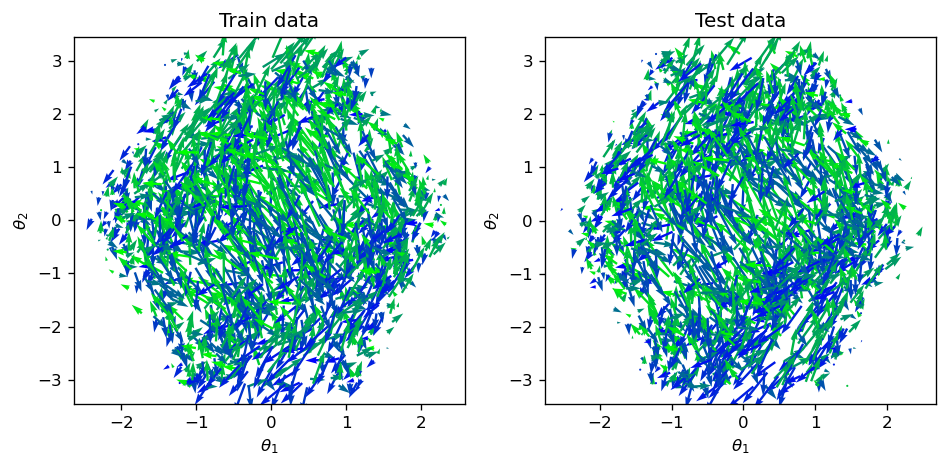

In [9]:
# preprocess
train_vis = jax.vmap(normalize_dp)(x_train)
test_vis = jax.vmap(normalize_dp)(x_test)

vel_angle = lambda data:  (np.arctan2(data[:,3], data[:,2]) / np.pi + 1)/2
vel_color = lambda vangle: np.stack( [np.zeros_like(vangle), vangle, 1-vangle]).T
train_colors = vel_color(vel_angle(train_vis))
test_colors = vel_color(vel_angle(test_vis))

# plot
SCALE = 80 ; WIDTH = 0.006
plt.figure(figsize=[8,4], dpi=120)
plt.subplot(1,2,1)
plt.title("Train data") ; plt.xlabel(r'$\theta_1$') ; plt.ylabel(r'$\theta_2$')
plt.quiver(*train_vis.T, color=train_colors, scale=SCALE, width=WIDTH)

plt.subplot(1,2,2)
plt.title("Test data") ; plt.xlabel(r'$\theta_1$') ; plt.ylabel(r'$\theta_2$')
plt.quiver(*test_vis.T, color=test_colors, scale=SCALE, width=WIDTH)

plt.tight_layout() ; plt.show()

### Création du modèle et de la fonction de loss


In [10]:
# replace the lagrangian with a parameteric model
def learned_lagrangian(params):
  def lagrangian(q, q_t):
    assert q.shape == (2,)
    state = normalize_dp(jnp.concatenate([q, q_t]))
    return jnp.squeeze(nn_forward_fn(params, state), axis=-1)
  return lagrangian

# define the loss of the model (MSE between predicted q, \dot q and targets)
@jax.jit
def loss(params, batch, time_step=None):
  state, targets = batch
  if time_step is not None:
    f = partial(equation_of_motion, learned_lagrangian(params))
    preds = jax.vmap(partial(rk4_step, f, t=0.0, h=time_step))(state)
  else:
    preds = jax.vmap(partial(equation_of_motion, learned_lagrangian(params)))(state)
  return jnp.mean((preds - targets) ** 2)

# build a neural network model
init_random_params, nn_forward_fn = stax.serial(
    stax.Dense(128),
    stax.Softplus,
    stax.Dense(128),
    stax.Softplus,
    stax.Dense(1),
)

### Optimisation

In [11]:
@jax.jit
def update_timestep(i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, jax.grad(loss)(params, batch, time_step), opt_state)

@jax.jit
def update_derivative(i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, jax.grad(loss)(params, batch, None), opt_state)

x_train = jax.device_put(jax.vmap(normalize_dp)(x_train))
y_train = jax.device_put(y_train)

x_test = jax.device_put(jax.vmap(normalize_dp)(x_test))
y_test = jax.device_put(y_test)

### Phase de training


In [12]:


rng = jax.random.PRNGKey(0)
_, init_params = init_random_params(rng, (-1, 4))

# numbers in comments denote stephan's settings
batch_size = 100
test_every = 10
num_batches = 1500

train_losses = []
test_losses = []

# adam w learn rate decay
opt_init, opt_update, get_params = optimizers.adam(
    lambda t: jnp.select([t < batch_size*(num_batches//3),
                          t < batch_size*(2*num_batches//3),
                          t > batch_size*(2*num_batches//3)],
                         [1e-3, 3e-4, 1e-4]))
opt_state = opt_init(init_params)

for iteration in range(batch_size*num_batches + 1):
  if iteration % batch_size == 0:
    params = get_params(opt_state)
    train_loss = loss(params, (x_train, xt_train))
    train_losses.append(train_loss)
    test_loss = loss(params, (x_test, xt_test))
    test_losses.append(test_loss)
    if iteration % (batch_size*test_every) == 0:
      print(f"iteration={iteration}, train_loss={train_loss:.6f}, test_loss={test_loss:.6f}")
  opt_state = update_derivative(iteration, opt_state, (x_train, xt_train))

params = get_params(opt_state)

iteration=0, train_loss=2755.000977, test_loss=5547.864746


KeyboardInterrupt: 

### Enregistrement ou chargement des paramètres

Cette section permet d'enregistrer les paramètres du LNN ou d'en charger.

In [3]:
import pickle

#### Chargement du modèle

In [14]:
# Chemin du fichier pickle
fichier_pickle = "params_Timestep_0.007_2100batches_N1600.pkl"

# Chargement de la variable
with open(fichier_pickle, "rb") as fichier:
    params = pickle.load(fichier)

### Evolution des losses

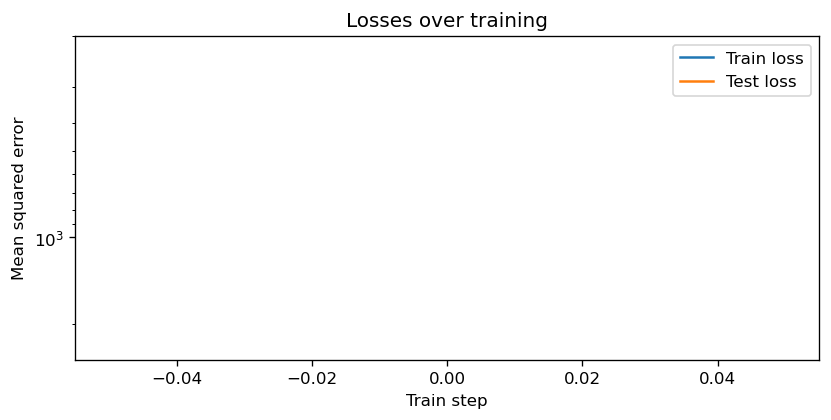

In [16]:
plt.figure(figsize=(8, 3.5), dpi=120)
plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='Test loss')
plt.yscale('log')
plt.ylim(None, 200)
plt.title('Losses over training')
plt.xlabel("Train step") ; plt.ylabel("Mean squared error")
plt.legend() ; plt.show()

# Baseline NN - Réseau de Neuronnes simple

On va créer le NN baseline

In [4]:
# Paramètres physiques
g = 9.81  # Gravité
L1, L2 = 1.0, 1.0  # Longueurs des bras
m1, m2 = 1.0, 1.0  # Masses

On recrée une fonction analytique pour pouvoir sampler les trajectoires

In [5]:
def double_pendulum(t, y):
    theta1, theta2, theta1_dot, theta2_dot = y
    delta = theta1 - theta2

    theta1_ddot = (
        -g * (2 * m1 + m2) * np.sin(theta1)
        - m2 * g * np.sin(theta1 - 2 * theta2)
        - 2 * np.sin(delta) * m2 * (theta2_dot**2 * L2 + theta1_dot**2 * L1 * np.cos(delta))
    ) / (L1 * (2 * m1 + m2 - m2 * np.cos(2 * delta)))

    theta2_ddot = (
        2
        * np.sin(delta)
        * (
            theta1_dot**2 * L1 * (m1 + m2)
            + g * (m1 + m2) * np.cos(theta1)
            + theta2_dot**2 * L2 * m2 * np.cos(delta)
        )
    ) / (L2 * (2 * m1 + m2 - m2 * np.cos(2 * delta)))

    return [theta1_dot, theta2_dot, theta1_ddot, theta2_ddot]

### Création de la data d'entrainement.

In [6]:
def generate_double_pendulum_data(num_samples, t_span, y0_range):
    """Génère des données pour le double pendule."""
    X, y = [], []
    for _ in range(num_samples):
        y0 = np.random.uniform(*y0_range, size=4)  # Conditions initiales
        sol = solve_ivp(double_pendulum, t_span, y0, t_eval=[t_span[0]])
        theta1, theta2, theta1_dot, theta2_dot = sol.y[:, 0]
        theta1_ddot, theta2_ddot = double_pendulum(0, [theta1, theta2, theta1_dot, theta2_dot])[2:]
        X.append([theta1, theta2, theta1_dot, theta2_dot])
        y.append([theta1_ddot, theta2_ddot])
    return np.array(X), np.array(y)

In [ ]:
t_span = [0, 0.01]
y0_range = [-np.pi, np.pi]
X_train, y_train = generate_double_pendulum_data(100000, t_span, y0_range)

Visualisation des données d'entrainement.

In [ ]:
plt.plot(X_train[:, 0], X_train[:, 2], 'o', markersize=2)
plt.xlabel('$\\theta_1$')
plt.ylabel('$\\dot{\\theta}_1$')
plt.title('Données d\'entrainement')
plt.show()

### On définit le modèle du NN

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='softplus', input_shape=(4,)),
    tf.keras.layers.Dense(128, activation='softplus'),
    tf.keras.layers.Dense(2)  # Deux sorties : theta1_ddot et theta2_ddot
])

model.compile(optimizer='adam', loss='mse')
model.summary()

On le fait train sur notre data

In [ ]:
model.fit(X_train, y_train, epochs=300, batch_size=64, verbose=1)

## Construction d'une trajectoire à partir d'une condition initiale

In [ ]:
# Intégration pour prédire une trajectoire
def integrate_trajectory_double_pendulum(y0, dt, steps, model):
    """Construit une trajectoire en utilisant le NN et l'intégration d'Euler."""
    trajectory = [y0]
    y = np.array(y0)
    for _ in range(steps):
        y_ddot = model.predict(y[np.newaxis, :], verbose=0)[0]    #verbose = 0 permet de désactiver l'affichage des logs
        y[2:] += y_ddot * dt  # Mise à jour des vitesses angulaires
        y[:2] += y[2:] * dt  # Mise à jour des angles
        trajectory.append(y.copy())
    return np.array(trajectory)

In [ ]:
# Trajectoire avec le NN
y0 = [np.pi / 4, np.pi/2, 0.0, 0.0]  # Conditions initiales
dt = 0.02
steps = 2000
trajectory_nn = integrate_trajectory_double_pendulum(y0, dt, steps, model)

In [ ]:
# Visualisation des angles
time = np.linspace(0, steps * dt, steps + 1)
plt.figure(figsize=(12, 6))
plt.plot(time, trajectory_nn[:, 0], label='$\\theta_1$ (NN)', linestyle='--')
plt.plot(time, trajectory_nn[:, 1], label='$\\theta_2$ (NN)', linestyle='--')
plt.xlabel("Temps (s)")
plt.ylabel("Angles (rad)")
plt.legend()
plt.title("Trajectoire prédite par le réseau de neurones")
plt.show()

On va vérifier l'énergie désormais

In [ ]:
def check_energy(th1, th2, w1, w2, m1=1, m2=1, l1=1, l2=1, g=9.8):

  T = 0.5*(m1 + m2)*l1**2*w1**2 + 0.5*m2*l2**2*w2**2 + m2*l1*l2*w1*w2*jnp.cos(th1 - th2)
  V = (m1+m2)*g*l1*jnp.cos(th1) + m2*g*l2*jnp.cos(th2)

  return T - V

# Visualisation et comparaison des résultats.

<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
/var/folders/_5/450_dsxx7pqfnwb2rs5wpndm0000gn/T/ipykernel_45895/202543221.py:5: SyntaxWarning: invalid escape sequence '\d'
  axes[0].set_title('Predicting $\dot q$')
/var/folders/_5/450_dsxx7pqfnwb2rs5wpndm0000gn/T/ipykernel_45895/202543221.py:6: SyntaxWarning: invalid escape sequence '\d'
  axes[0].set_xlabel('$\dot q$ actual')
/var/folders/_5/450_dsxx7pqfnwb2rs5wpndm0000gn/T/ipykernel_4589

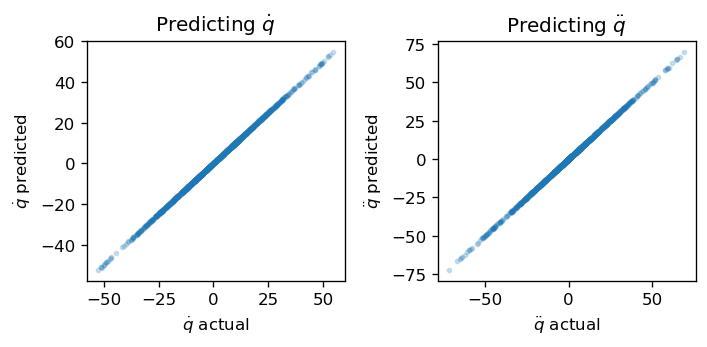

In [15]:
xt_pred = jax.vmap(partial(equation_of_motion, learned_lagrangian(params)))(x_test)

fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=120)
axes[0].scatter(xt_test[:, 2], xt_pred[:, 2], s=6, alpha=0.2)
axes[0].set_title('Predicting $\dot q$')
axes[0].set_xlabel('$\dot q$ actual')
axes[0].set_ylabel('$\dot q$ predicted')
axes[1].scatter(xt_test[:, 3], xt_pred[:, 3], s=6, alpha=0.2)
axes[1].set_title('Predicting $\ddot q$')
axes[1].set_xlabel('$\ddot q$ actual')
axes[1].set_ylabel('$\ddot q$ predicted')
plt.tight_layout()

plt.savefig('1_1_mapping.pdf', bbox_inches='tight')

## Predictions with the model

Premières simulation avec une certaine condition initiale

In [23]:
# choose an initial state
#x1 = np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32) # C'est la condition sur laquelle a été train le LNN
#x1 = np.array([np.pi/4, 0, 0, 0], dtype=np.float32) # Condition initiale beaucoup moins chaotique.
x1 = np.array([np.pi/4, 0, 0.5, 1], dtype=np.float32) # Condition pour laquelle ça marche vraiment très bien.

#t2 = np.linspace(0, 20, num=301)

t2 = np.linspace(0, 50, num=401)

%time x1_analytical = jax.device_get(solve_analytical(x1, t2))
noise_coeff_3 = 1e-3
%time x1_perturbed = jax.device_get(solve_analytical(x1 + noise_coeff_3 * noise, t2))
%time x1_model = jax.device_get(solve_lagrangian(learned_lagrangian(params), x1, t=t2))

xt = jax.device_get(jax.vmap(f_analytical)(x1_analytical))
xt_model = jax.device_get(jax.vmap(partial(equation_of_motion, learned_lagrangian(params))))(x1_model)

xtry = jax.device_get(jax.vmap(f_analytical)(x1_model))

#x1_autograd = jax.device_get(solve_autograd(x1_model, t2))

CPU times: user 25.1 ms, sys: 3.36 ms, total: 28.5 ms
Wall time: 63 ms
CPU times: user 18.8 ms, sys: 477 μs, total: 19.3 ms
Wall time: 24.8 ms
CPU times: user 2.21 s, sys: 38 ms, total: 2.25 s
Wall time: 2.24 s


In [24]:
def check_energy(th1, th2, w1, w2, m1=1, m2=1, l1=1, l2=1, g=9.8):

  T = 0.5*(m1 + m2)*l1**2*w1**2 + 0.5*m2*l2**2*w2**2 + m2*l1*l2*w1*w2*jnp.cos(th1 - th2)
  V = (m1+m2)*g*l1*jnp.cos(th1) + m2*g*l2*jnp.cos(th2)

  return T - V

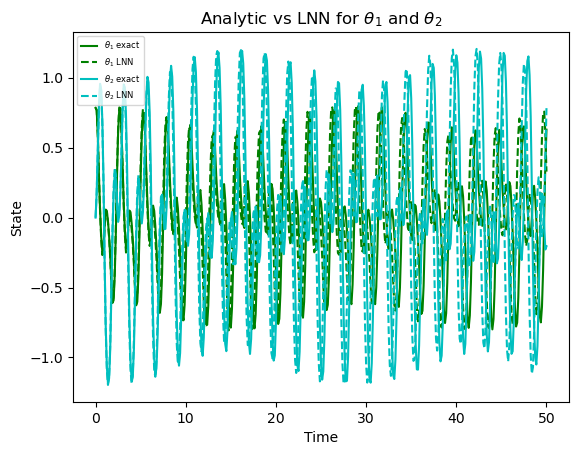

In [25]:
#plt.figure(figsize=[9,6], dpi=120) ; plt.xlim(0, 20)
plt.title(r"Analytic vs LNN for $\theta_1$ and $\theta_2$")
plt.xlabel("Time") ; plt.ylabel("State")
plt.plot(t2, x1_analytical[:, 0], 'g-', label=r'$\theta_1$ exact')
plt.plot(t2, x1_model[:, 0], 'g--', label=r'$\theta_1$ LNN')
plt.plot(t2, x1_analytical[:, 1], 'c-', label=r'$\theta_2$ exact')
plt.plot(t2, x1_model[:, 1], 'c--', label=r'$\theta_2$ LNN')
plt.legend(fontsize=6)

#plt.savefig("Trajectories.pdf", bbox_inches="tight")

On peut visualiser l'énergie

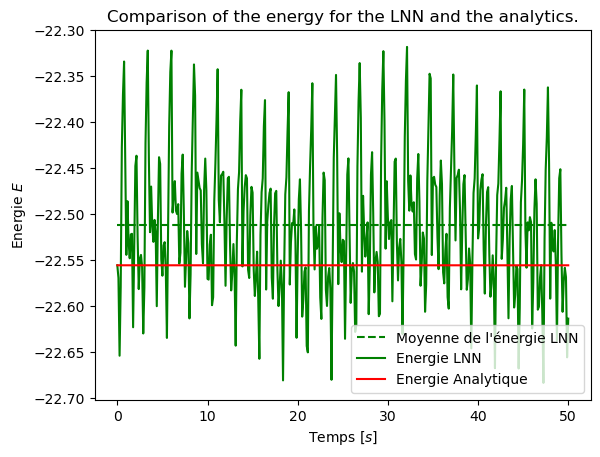

In [26]:
x_analy = jax.device_get(solve_analytical(x1, t2))

energy_analytique = check_energy(x_analy[:,0], x_analy[:,1], x_analy[:,2], x_analy[:,3])
energy_pred_LNN = check_energy(x1_model[:,0], x1_model[:,1], x1_model[:,2], x1_model[:,3])

plt.plot(t2, np.mean(energy_pred_LNN)*np.ones(len(t2)), color='green', linestyle ="dashed", label="Moyenne de l'énergie LNN")
plt.plot(t2, energy_pred_LNN, 'g-', label=r'Energie LNN')
plt.plot(t2, energy_analytique, label='Energie Analytique', color='red')


plt.xlabel("Temps [$s$]")
plt.ylabel("Energie $E$")
plt.title("Comparison of the energy for the LNN and the analytics.")

plt.legend()

#plt.savefig("EnergieLNN.pdf", bbox_inches="tight")

On peut regarder les trajectoires des masses $m_1$ et $m_2$ pour voir.

<>:24: SyntaxWarning: invalid escape sequence '\e'
<>:24: SyntaxWarning: invalid escape sequence '\e'
/var/folders/_5/450_dsxx7pqfnwb2rs5wpndm0000gn/T/ipykernel_36673/116788044.py:24: SyntaxWarning: invalid escape sequence '\e'
  """


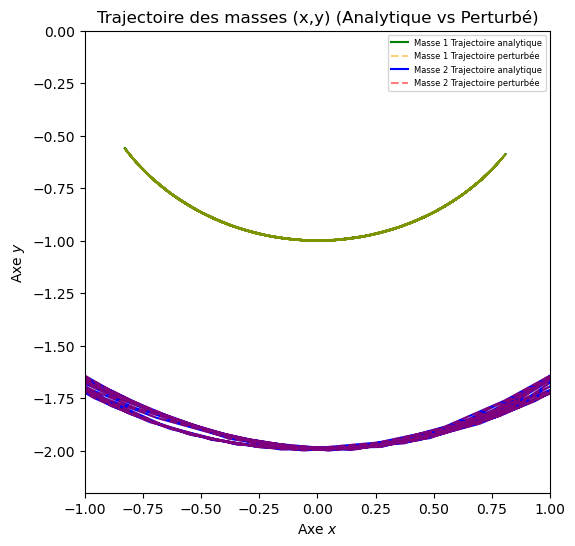

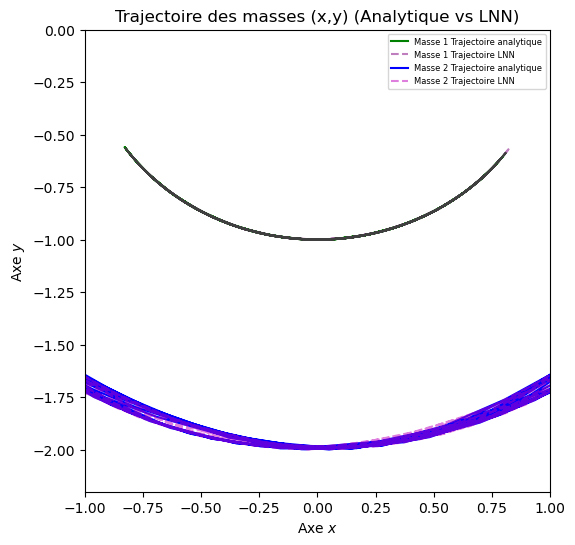

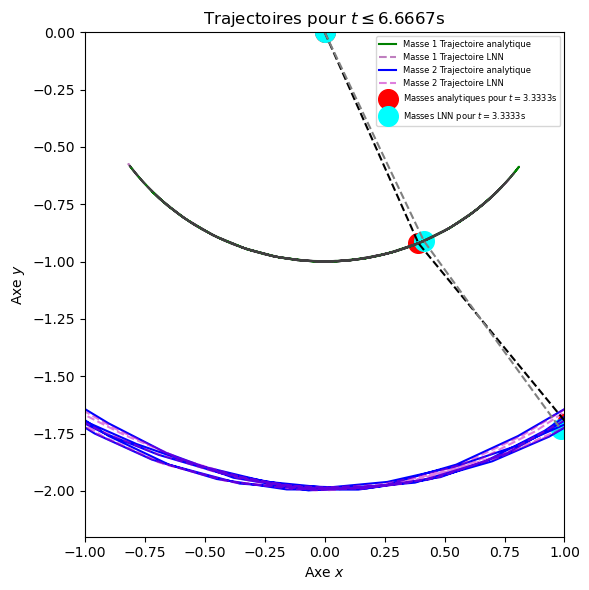

In [75]:
#Assuming l1 = l2 = 1
l1, l2 = 1, 1

# Calculate Cartesian coordinates for each pendulum mass
# Analytical case
x1_cartesian_analytical = l1 * np.sin(x1_analytical[:, 0])
y1_cartesian_analytical = -l1 * np.cos(x1_analytical[:, 0])
x2_cartesian_analytical = x1_cartesian_analytical + l2 * np.sin(x1_analytical[:, 1])
y2_cartesian_analytical = y1_cartesian_analytical - l2 * np.cos(x1_analytical[:, 1])

# Perturbed case
x1_cartesian_perturbed = l1 * np.sin(x1_perturbed[:, 0])
y1_cartesian_perturbed = -l1 * np.cos(x1_perturbed[:, 0])
x2_cartesian_perturbed = x1_cartesian_perturbed + l2 * np.sin(x1_perturbed[:, 1])
y2_cartesian_perturbed = y1_cartesian_perturbed - l2 * np.cos(x1_perturbed[:, 1])

# Model predictions case
x1_cartesian_model = l1 * np.sin(x1_model[:, 0])
y1_cartesian_model = -l1 * np.cos(x1_model[:, 0])
x2_cartesian_model = x1_cartesian_model + l2 * np.sin(x1_model[:, 1])
y2_cartesian_model = y1_cartesian_model - l2 * np.cos(x1_model[:, 1])


"""
# First plot: angles vs time
plt.figure(figsize = [9,6])
plt.title("Analytic vs Perturbed ($\epsilon$={})".format(noise_coeff_3))
plt.xlabel("Time")
plt.ylabel("State")
plt.plot(t2, x1_analytical[:, 0], 'g-', label=r'$\theta_1$ exact')
plt.plot(t2, x1_analytical[:, 1], 'c-', label=r'$\theta_2$ exact')
plt.plot(t2, x1_perturbed[:, 0], 'g--', label=r'$\theta_1$ perturbed')
plt.plot(t2, x1_perturbed[:, 1], 'c--', label=r'$\theta_2$ perturbed')
plt.legend(fontsize=6)

# Second plot: analytic vs model
plt.figure(figsize = [9,6])
plt.title("Analytic vs LNN")
plt.xlabel("Time")
plt.ylabel("State")
plt.plot(t2, x1_analytical[:, 0], 'g-', label=r'$\theta_1$ exact')
plt.plot(t2, x1_analytical[:, 1], 'c-', label=r'$\theta_2$ exact')
plt.plot(t2, x1_model[:, 0], 'g--', label=r'$\theta_1$ LNN')
plt.plot(t2, x1_model[:, 1], 'c--', label=r'$\theta_2$ LNN')
plt.legend(fontsize=6)
"""

# Third plot: trajectory of both masses (analytical and perturbed)
plt.figure(figsize = [6,6])
plt.title("Trajectoire des masses (x,y) (Analytique vs Perturbé)")
plt.xlabel(r"Axe $x$")
plt.ylabel(r"Axe $y$")
plt.ylim(-2.2, 0)
plt.xlim(-1, 1)
# Mass 1 trajectories
plt.plot(x1_cartesian_analytical, y1_cartesian_analytical, 'g-', label='Masse 1 Trajectoire analytique')
plt.plot(x1_cartesian_perturbed, y1_cartesian_perturbed, '--', color='orange', alpha=0.5, label='Masse 1 Trajectoire perturbée')
# Mass 2 trajectories
plt.plot(x2_cartesian_analytical, y2_cartesian_analytical, 'b-', label='Masse 2 Trajectoire analytique')
plt.plot(x2_cartesian_perturbed, y2_cartesian_perturbed, 'r--', alpha=0.5, label='Masse 2 Trajectoire perturbée')
plt.legend(fontsize=6)

# Fourth plot: trajectory of both masses using model predictions
plt.figure(figsize = [6,6])
plt.title("Trajectoire des masses (x,y) (Analytique vs LNN)")
plt.ylim(-2.2, 0)
plt.xlim(-1, 1)
plt.xlabel(r"Axe $x$")
plt.ylabel(r"Axe $y$")
# Mass 1 trajectories (Model)
plt.plot(x1_cartesian_analytical, y1_cartesian_analytical, 'g-', label='Masse 1 Trajectoire analytique')
plt.plot(x1_cartesian_model, y1_cartesian_model, '--', color='purple', alpha=0.5, label='Masse 1 Trajectoire LNN')
# Mass 2 trajectories (Model)
plt.plot(x2_cartesian_analytical, y2_cartesian_analytical, 'b-', label='Masse 2 Trajectoire analytique')
plt.plot(x2_cartesian_model, y2_cartesian_model, 'm--', alpha=0.5, label='Masse 2 Trajectoire LNN')
plt.legend(fontsize=6)

#plt.savefig("Masses_time_full.pdf", bbox_inches="tight")


# Fifth plot: trajectory of both masses using model predictions
plt.figure(figsize = [6,6])
plt.title(r"Trajectoires pour $t\leq$"+str(round(t2[100], 4))+"s")
plt.ylim(-2.2, 0)
plt.xlim(-1, 1)
plt.xlabel(r"Axe $x$")
plt.ylabel(r"Axe $y$")
# Mass 1 trajectories (Model)
plt.plot(x1_cartesian_analytical[:100], y1_cartesian_analytical[:100], 'g-', label='Masse 1 Trajectoire analytique')
plt.plot(x1_cartesian_model[:100], y1_cartesian_model[:100], '--', color='purple', alpha=0.5, label='Masse 1 Trajectoire LNN')
# Mass 2 trajectories (Model)
plt.plot(x2_cartesian_analytical[:100], y2_cartesian_analytical[:100], 'b-', label='Masse 2 Trajectoire analytique')
plt.plot(x2_cartesian_model[:100], y2_cartesian_model[:100], 'm--', alpha=0.5, label='Masse 2 Trajectoire LNN')

#Représentation d'un pendule
plt.plot([0, x1_cartesian_analytical[50], x2_cartesian_analytical[50]], [0, y1_cartesian_analytical[50], y2_cartesian_analytical[50]], '--', color='black')
plt.scatter([0, x1_cartesian_analytical[50], x2_cartesian_analytical[50]], [0, y1_cartesian_analytical[50], y2_cartesian_analytical[50]], color='red', s=200, label='Masses analytiques pour $t=$'+str(round(t2[50], 4))+'s')

plt.plot([0, x1_cartesian_model[50], x2_cartesian_model[50]], [0, y1_cartesian_model[50], y2_cartesian_model[50]], '--', color='gray')
plt.scatter([0, x1_cartesian_model[50], x2_cartesian_model[50]], [0, y1_cartesian_model[50], y2_cartesian_model[50]], color='cyan', s=200, label='Masses LNN pour $t=$'+str(round(t2[50], 4))+'s')

plt.legend(fontsize=6)

plt.legend(fontsize=6)

#plt.savefig("Masses_time_crop.pdf", bbox_inches="tight")

plt.tight_layout()
plt.show()


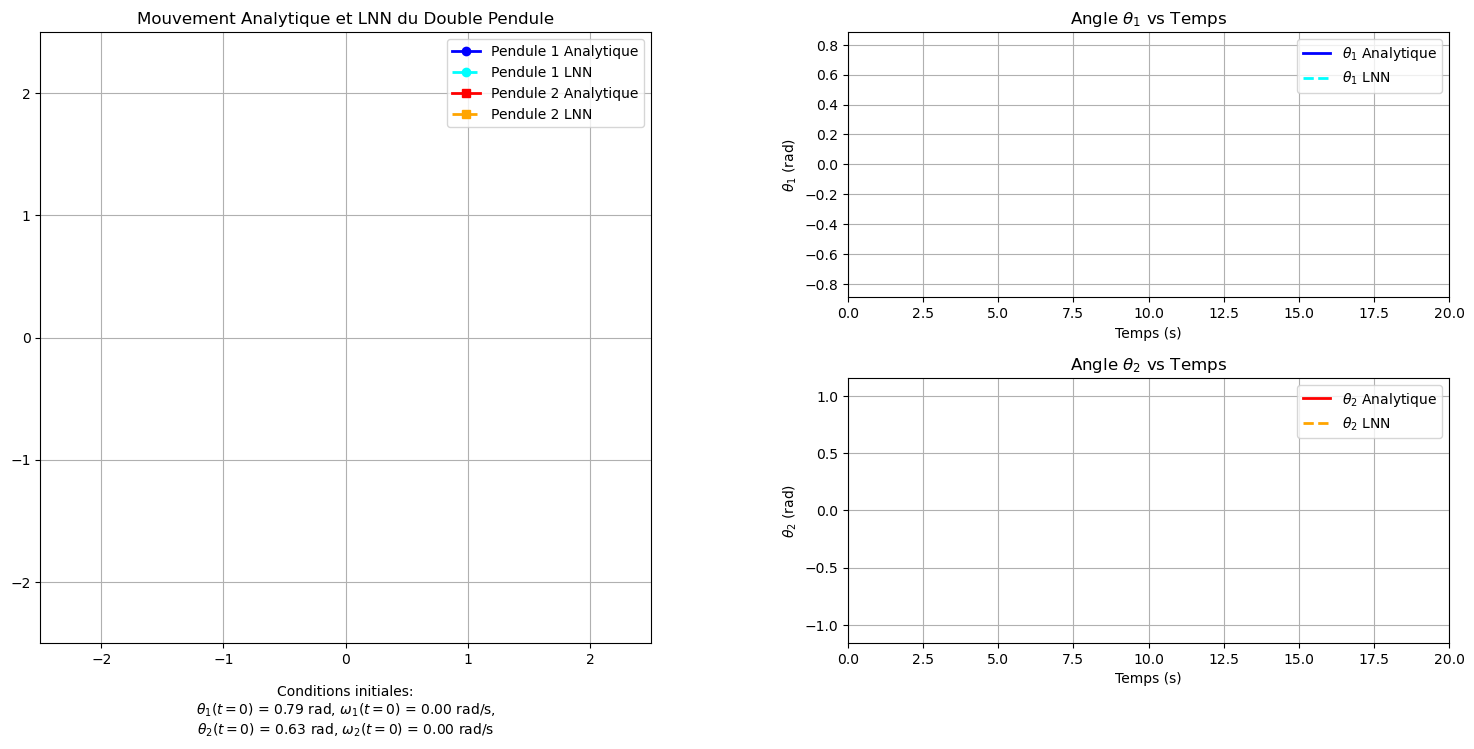

MovieWriter imagemagick unavailable; using Pillow instead.


ValueError: unknown file extension: .gif3

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Assurez-vous que les données t2, x1_analytical et x1_model sont définies avant d'exécuter ce script
# Exemple de définition des données (à remplacer par vos données réelles)
# t2 = np.linspace(0, 20, 1000)
# x1_analytical = np.zeros((1000, 4))  # Columns: theta1, theta2, omega1, omega2
# x1_model = np.zeros((1000, 4))        # Columns: theta1_LNN, theta2_LNN, omega1_LNN, omega2_LNN

# Exemple de données simulées pour le test (à remplacer par vos données réelles)
# Ceci est uniquement pour tester l'animation. Remplacez-le par vos propres données.
# =====================
# Extract Angles and Angular Velocities
# =====================
theta_1, theta_2 = x1_analytical[:, 0], x1_analytical[:, 1]
theta_1_LNN, theta_2_LNN = x1_model[:, 0], x1_model[:, 1]
omega1, omega2 = x1_analytical[:, 2], x1_analytical[:, 3]
omega1_LNN, omega2_LNN = x1_model[:, 2], x1_model[:, 3]

# =====================
# Time Parameters
# =====================
dt = t2[1] - t2[0]
t_max = np.max(t2)

# =====================
# Pendulum Parameters
# =====================
L1 = 1.0  # Length of pendulum 1 (meters)
L2 = 1.0  # Length of pendulum 2 (meters)

# =====================
# Origin Position
# =====================
x_origin = 0    # X position of the fixed origin
y_origin = 0    # Y position of the fixed origin

# =====================
# Calculate Mass Positions (Analytical)
# =====================
# Pendulum 1 oscillates in the x-y plane
x1_analytic_pos = x_origin + L1 * np.sin(theta_1)
y1_analytic_pos = y_origin - L1 * np.cos(theta_1)

# Pendulum 2 is attached to the end of pendulum 1
x2_analytic_pos = x1_analytic_pos + L2 * np.sin(theta_2)
y2_analytic_pos = y1_analytic_pos - L2 * np.cos(theta_2)

# =====================
# Calculate Mass Positions (LNN)
# =====================
# Pendulum 1 LNN oscillates in the x-y plane
x1_LNN_pos = x_origin + L1 * np.sin(theta_1_LNN)
y1_LNN_pos = y_origin - L1 * np.cos(theta_1_LNN)

# Pendulum 2 LNN is attached to the end of pendulum 1 LNN
x2_LNN_pos = x1_LNN_pos + L2 * np.sin(theta_2_LNN)
y2_LNN_pos = y1_LNN_pos - L2 * np.cos(theta_2_LNN)

# =====================
# Create Figure and Subplots
# =====================
fig = plt.figure(figsize=(14, 6))
gs = fig.add_gridspec(1, 2, width_ratios=[2, 3])

# ---------------------
# Subplot 1: 2D Animation of Double Pendulum
# ---------------------
ax_anim = fig.add_subplot(gs[0])

# Définir les limites des axes
ax_anim.set_xlim(- (L1 + L2) - 0.5, L1 + L2 + 0.5)
ax_anim.set_ylim(- (L1 + L2) - 0.5, L1 + L2 + 0.5)

# Configurer l’aspect et les titres
ax_anim.set_aspect('equal')
ax_anim.set_title("Mouvement Analytique et LNN du Double Pendule")
ax_anim.grid(True)

# Initialiser les lignes pour les pendules analytiques et LNN
line1_analytic, = ax_anim.plot([], [], 'o-', lw=2, color='blue', label='Pendule 1 Analytique')
line1_LNN, = ax_anim.plot([], [], 'o--', lw=2, color='cyan', label='Pendule 1 LNN')
line2_analytic, = ax_anim.plot([], [], 's-', lw=2, color='red', label='Pendule 2 Analytique')
line2_LNN, = ax_anim.plot([], [], 's--', lw=2, color='orange', label='Pendule 2 LNN')
time_text_anim = ax_anim.text(0.05, 0.95, '', transform=ax_anim.transAxes)

ax_anim.legend(frameon=True, loc='upper right')

# ---------------------
# Subplot 2: Angle Plots
# ---------------------
ax_plot = fig.add_subplot(gs[1])
ax_plot.set_xlim(0, t_max)
y_min = min(theta_1.min(), theta_1_LNN.min(), theta_2.min(), theta_2_LNN.min()) - 0.1
y_max = max(theta_1.max(), theta_1_LNN.max(), theta_2.max(), theta_2_LNN.max()) + 0.1
ax_plot.set_ylim(y_min, y_max)
ax_plot.set_title("Angles vs Temps")
ax_plot.set_xlabel("Temps (s)")
ax_plot.set_ylabel("Angles (rad)")
ax_plot.grid(True)

# Initialiser les lignes pour les angles
line_theta1_analytic, = ax_plot.plot([], [], '-', lw=2, color='blue', label=r'$\theta_1$ Analytique')
line_theta1_LNN, = ax_plot.plot([], [], '--', lw=2, color='cyan', label=r'$\theta_1$ LNN')
line_theta2_analytic, = ax_plot.plot([], [], '-', lw=2, color='red', label=r'$\theta_2$ Analytique')
line_theta2_LNN, = ax_plot.plot([], [], '--', lw=2, color='orange', label=r'$\theta_2$ LNN')

ax_plot.legend(frameon=True, loc='upper right')

# =====================
# Initialize Data Lists
# =====================
theta1_analytic_data = []
theta1_LNN_data = []
theta2_analytic_data = []
theta2_LNN_data = []
time_data = []

# =====================
# Add Initial Conditions Text
# =====================
# Récupérer les conditions initiales
theta1_analytic_init = theta_1[0]
omega1_init = omega1[0]
theta2_analytic_init = theta_2[0]
omega2_init = omega2[0]

theta1_LNN_init = theta_1_LNN[0]
omega1_LNN_init = omega1_LNN[0]
theta2_LNN_init = theta_2_LNN[0]
omega2_LNN_init = omega2_LNN[0]

# Créer des chaînes formatées avec LaTeX
initial_conditions = (
    f"Conditions initiales:\n"
    f"$\\theta_1(t=0)$ = {theta1_analytic_init:.2f} rad, "
    f"$\\omega_1(t=0)$ = {omega1_init:.2f} rad/s,\n"
    f"$\\theta_2(t=0)$ = {theta2_analytic_init:.2f} rad, "
    f"$\\omega_2(t=0)$ = {omega2_init:.2f} rad/s"
)

# Ajouter le texte sous le subplot d'animation
ax_anim.text(0.5, -0.15, initial_conditions,
             transform=ax_anim.transAxes, ha='center', fontsize=10)

# Ajouter le texte sous le subplot des graphiques
#ax_plot.text(0.5, -0.2, initial_conditions, transform=ax_plot.transAxes, ha='center', fontsize=10)

# =====================
# Animation Initialization
# =====================
def init():
    # Initialiser les lignes des pendules analytiques
    line1_analytic.set_data([], [])
    line2_analytic.set_data([], [])
    
    # Initialiser les lignes des pendules LNN
    line1_LNN.set_data([], [])
    line2_LNN.set_data([], [])
    
    # Initialiser les lignes des angles
    line_theta1_analytic.set_data([], [])
    line_theta1_LNN.set_data([], [])
    line_theta2_analytic.set_data([], [])
    line_theta2_LNN.set_data([], [])
    
    # Initialiser le texte du temps
    time_text_anim.set_text('')
    
    return (line1_analytic, line1_LNN, line2_analytic, line2_LNN,
            line_theta1_analytic, line_theta1_LNN, line_theta2_analytic, line_theta2_LNN,
            time_text_anim)

# =====================
# Animation Update Function
# =====================
def update(frame):
    # Mettre à jour le pendule 1 Analytique
    x1_analytic = [x_origin, x1_analytic_pos[frame]]
    y1_analytic = [y_origin, y1_analytic_pos[frame]]
    line1_analytic.set_data(x1_analytic, y1_analytic)
    
    # Mettre à jour le pendule 1 LNN
    x1_LNN = [x_origin, x1_LNN_pos[frame]]
    y1_LNN = [y_origin, y1_LNN_pos[frame]]
    line1_LNN.set_data(x1_LNN, y1_LNN)
    
    # Mettre à jour le pendule 2 Analytique
    x2_analytic = [x1_analytic_pos[frame], x2_analytic_pos[frame]]
    y2_analytic = [y1_analytic_pos[frame], y2_analytic_pos[frame]]
    line2_analytic.set_data(x2_analytic, y2_analytic)
    
    # Mettre à jour le pendule 2 LNN
    x2_LNN = [x1_LNN_pos[frame], x2_LNN_pos[frame]]
    y2_LNN = [y1_LNN_pos[frame], y2_LNN_pos[frame]]
    line2_LNN.set_data(x2_LNN, y2_LNN)
    
    # Mettre à jour le texte du temps
    current_time = frame * dt
    time_text_anim.set_text(f'Temps = {current_time:.2f} s')
    
    # Mettre à jour les graphiques des angles
    time_data.append(current_time)
    theta1_analytic_data.append(theta_1[frame])
    theta1_LNN_data.append(theta_1_LNN[frame])
    theta2_analytic_data.append(theta_2[frame])
    theta2_LNN_data.append(theta_2_LNN[frame])
    
    line_theta1_analytic.set_data(time_data, theta1_analytic_data)
    line_theta1_LNN.set_data(time_data, theta1_LNN_data)
    line_theta2_analytic.set_data(time_data, theta2_analytic_data)
    line_theta2_LNN.set_data(time_data, theta2_LNN_data)
    
    # Optionnel : Ajuster dynamiquement les limites de l'axe y si nécessaire
    # y_min_current = min(theta1_analytic_data + theta1_LNN_data + theta2_analytic_data + theta2_LNN_data) - 0.1
    # y_max_current = max(theta1_analytic_data + theta1_LNN_data + theta2_analytic_data + theta2_LNN_data) + 0.1
    # ax_plot.set_ylim(y_min_current, y_max_current)
    
    return (line1_analytic, line1_LNN, line2_analytic, line2_LNN,
            line_theta1_analytic, line_theta1_LNN, line_theta2_analytic, line_theta2_LNN,
            time_text_anim)

# =====================
# Create and Display Animation
# =====================
ani = FuncAnimation(fig, update, frames=len(t2),
                    init_func=init, blit=False, interval=dt*1000, repeat=True)

# Ajuster la mise en page pour accommoder le texte des conditions initiales
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Laisser de l'espace en bas pour le texte

# Afficher l'animation
plt.show()

# =====================
# Optional: Save the Animation
# =====================
# Pour enregistrer l'animation au format MP4, assurez-vous que FFmpeg est installé
# Décommentez les lignes suivantes pour enregistrer l'animation

# ani.save('double_pendulum_LNN.mp4', writer='ffmpeg', fps=30)

# Pour enregistrer l'animation au format GIF, assurez-vous qu'ImageMagick est installé
# Décommentez la ligne suivante pour enregistrer l'animation en GIF

ani.save('double_pendulum3.gif', writer='imagemagick', fps=30)

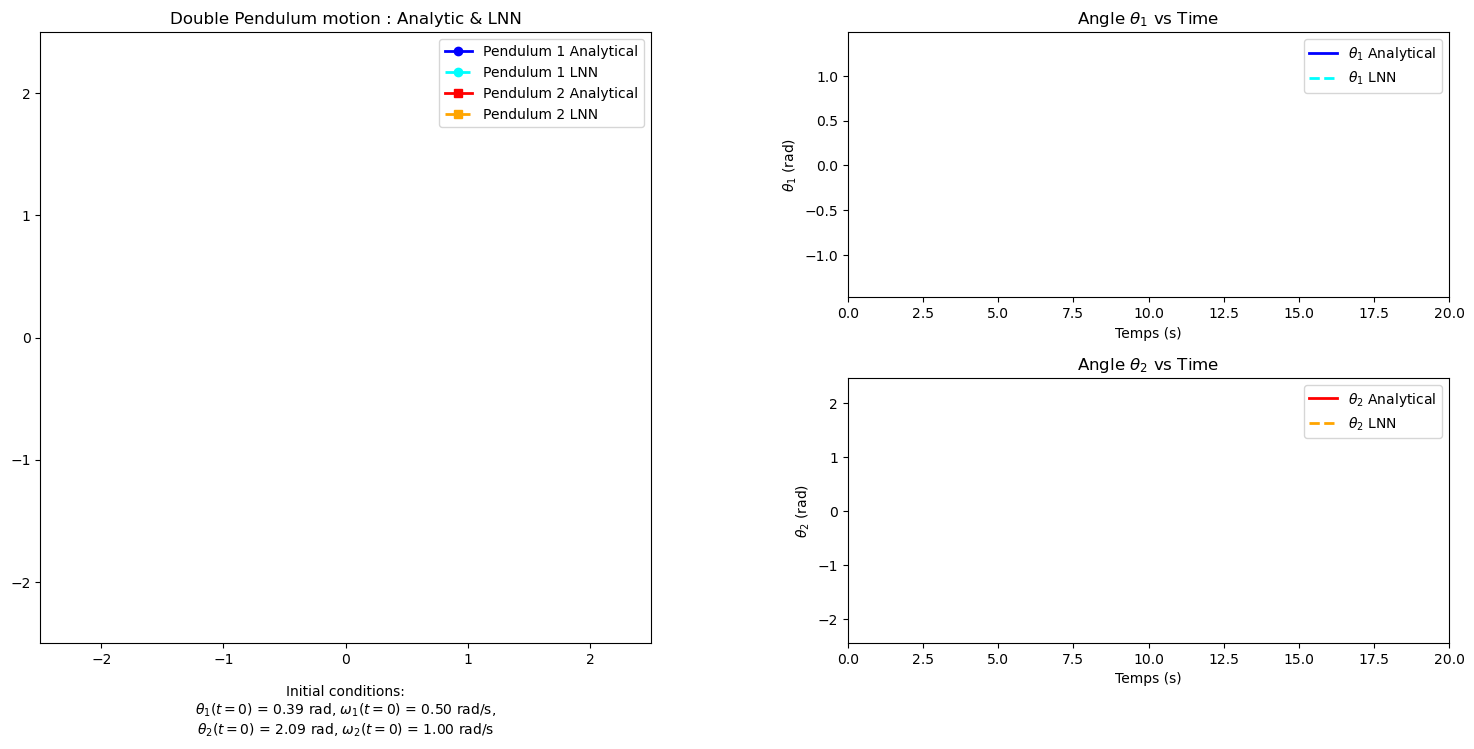

MovieWriter imagemagick unavailable; using Pillow instead.


KeyboardInterrupt: 

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Assurez-vous que les données t2, x1_analytical et x1_model sont définies avant d'exécuter ce script
# Exemple de définition des données (à remplacer par vos données réelles)
# t2 = np.linspace(0, 20, 1000)
# x1_analytical = np.zeros((1000, 4))  # Colonnes: theta1, theta2, omega1, omega2
# x1_model = np.zeros((1000, 4))        # Colonnes: theta1_LNN, theta2_LNN, omega1_LNN, omega2_LNN

# =====================
# Extraction des Angles et Vitesses Angulaires
# =====================
theta_1, theta_2 = x1_analytical[:, 0], x1_analytical[:, 1]
theta_1_LNN, theta_2_LNN = x1_model[:, 0], x1_model[:, 1]
omega1, omega2 = x1_analytical[:, 2], x1_analytical[:, 3]
omega1_LNN, omega2_LNN = x1_model[:, 2], x1_model[:, 3]

# =====================
# Paramètres de Temps
# =====================
dt = t2[1] - t2[0]
t_max = np.max(t2)

# =====================
# Paramètres du Pendule
# =====================
L1 = 1.0  # Longueur du pendule 1 (mètres)
L2 = 1.0  # Longueur du pendule 2 (mètres)

# =====================
# Position de l'Origine
# =====================
x_origin = 0    # Position X de l'origine fixe
y_origin = 0    # Position Y de l'origine fixe

# =====================
# Calcul des Positions des Masses (Analytique)
# =====================
# Pendule 1 analytique
x1_analytic_pos = x_origin + L1 * np.sin(theta_1)
y1_analytic_pos = y_origin - L1 * np.cos(theta_1)

# Pendule 2 analytique (attaché à la fin du pendule 1)
x2_analytic_pos = x1_analytic_pos + L2 * np.sin(theta_2)
y2_analytic_pos = y1_analytic_pos - L2 * np.cos(theta_2)

# =====================
# Calcul des Positions des Masses (LNN)
# =====================
# Pendule 1 LNN
x1_LNN_pos = x_origin + L1 * np.sin(theta_1_LNN)
y1_LNN_pos = y_origin - L1 * np.cos(theta_1_LNN)

# Pendule 2 LNN (attaché à la fin du pendule 1 LNN)
x2_LNN_pos = x1_LNN_pos + L2 * np.sin(theta_2_LNN)
y2_LNN_pos = y1_LNN_pos - L2 * np.cos(theta_2_LNN)

# =====================
# Création de la Figure et des Subplots
# =====================
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 2], height_ratios=[1, 1])

# ---------------------
# Subplot 1: Animation 2D du Double Pendule
# ---------------------
ax_anim = fig.add_subplot(gs[:, 0])  # Occupy both rows in the first column

# Définir les limites des axes
ax_anim.set_xlim(- (L1 + L2) - 0.5, L1 + L2 + 0.5)
ax_anim.set_ylim(- (L1 + L2) - 0.5, L1 + L2 + 0.5)

# Configurer l’aspect et les titres
ax_anim.set_aspect('equal')
ax_anim.set_title("Double Pendulum motion : Analytic & LNN")
ax_anim.grid(False)

# Initialiser les lignes pour les pendules analytiques et LNN
line1_analytic, = ax_anim.plot([], [], 'o-', lw=2, color='blue', label='Pendulum 1 Analytical')
line1_LNN, = ax_anim.plot([], [], 'o--', lw=2, color='cyan', label='Pendulum 1 LNN')
line2_analytic, = ax_anim.plot([], [], 's-', lw=2, color='red', label='Pendulum 2 Analytical')
line2_LNN, = ax_anim.plot([], [], 's--', lw=2, color='orange', label='Pendulum 2 LNN')
time_text_anim = ax_anim.text(0.05, 0.95, '', transform=ax_anim.transAxes, fontsize=10, verticalalignment='top')

ax_anim.legend(frameon=True, loc='upper right')

# ---------------------
# Subplot 2: Graphique de theta1 vs Temps
# ---------------------
ax_theta1 = fig.add_subplot(gs[0, 1])
ax_theta1.set_xlim(0, t_max)
theta1_min = min(theta_1.min(), theta_1_LNN.min()) - 0.1
theta1_max = max(theta_1.max(), theta_1_LNN.max()) + 0.1
ax_theta1.set_ylim(theta1_min, theta1_max)
ax_theta1.set_title(r"Angle $\theta_1$ vs Time")
ax_theta1.set_xlabel("Temps (s)")
ax_theta1.set_ylabel(r"$\theta_1$ (rad)")
ax_theta1.grid(False)

# Initialiser les lignes pour theta1
line_theta1_analytic, = ax_theta1.plot([], [], '-', lw=2, color='blue', label=r'$\theta_1$ Analytical')
line_theta1_LNN, = ax_theta1.plot([], [], '--', lw=2, color='cyan', label=r'$\theta_1$ LNN')

ax_theta1.legend(frameon=True, loc='upper right')

# ---------------------
# Subplot 3: Graphique de theta2 vs Temps
# ---------------------
ax_theta2 = fig.add_subplot(gs[1, 1])
ax_theta2.set_xlim(0, t_max)
theta2_min = min(theta_2.min(), theta_2_LNN.min()) - 0.1
theta2_max = max(theta_2.max(), theta_2_LNN.max()) + 0.1
ax_theta2.set_ylim(theta2_min, theta2_max)
ax_theta2.set_title(r"Angle $\theta_2$ vs Time")
ax_theta2.set_xlabel("Temps (s)")
ax_theta2.set_ylabel(r"$\theta_2$ (rad)")
ax_theta2.grid(False)

# Initialiser les lignes pour theta2
line_theta2_analytic, = ax_theta2.plot([], [], '-', lw=2, color='red', label=r'$\theta_2$ Analytical')
line_theta2_LNN, = ax_theta2.plot([], [], '--', lw=2, color='orange', label=r'$\theta_2$ LNN')

ax_theta2.legend(frameon=True, loc='upper right')

# =====================
# Initialisation des Listes de Données
# =====================
theta1_analytic_data = []
theta1_LNN_data = []
theta2_analytic_data = []
theta2_LNN_data = []
time_data = []

# =====================
# Ajout du Texte des Conditions Initiales
# =====================
# Récupérer les conditions initiales
theta1_analytic_init = theta_1[0]
omega1_init = omega1[0]
theta2_analytic_init = theta_2[0]
omega2_init = omega2[0]

theta1_LNN_init = theta_1_LNN[0]
omega1_LNN_init = omega1_LNN[0]
theta2_LNN_init = theta_2_LNN[0]
omega2_LNN_init = omega2_LNN[0]

# Créer des chaînes formatées avec LaTeX
initial_conditions = (
    f"Initial conditions:\n"
    f"$\\theta_1(t=0)$ = {theta1_analytic_init:.2f} rad, "
    f"$\\omega_1(t=0)$ = {omega1_init:.2f} rad/s,\n"
    f"$\\theta_2(t=0)$ = {theta2_analytic_init:.2f} rad, "
    f"$\\omega_2(t=0)$ = {omega2_init:.2f} rad/s"
)

# Ajouter le texte sous le subplot d'animation
ax_anim.text(0.5, -0.15, initial_conditions,
             transform=ax_anim.transAxes, ha='center', fontsize=10)

# Ajouter le texte sous les subplots des graphiques
#ax_theta1.text(0.5, -0.2, initial_conditions,transform=ax_theta1.transAxes, ha='center', fontsize=10)
#ax_theta2.text(0.5, -0.2, initial_conditions, transform=ax_theta2.transAxes, ha='center', fontsize=10)

# =====================
# Fonction d'Initialisation de l'Animation
# =====================
def init():
    # Initialiser les lignes des pendules analytiques
    line1_analytic.set_data([], [])
    line2_analytic.set_data([], [])

    # Initialiser les lignes des pendules LNN
    line1_LNN.set_data([], [])
    line2_LNN.set_data([], [])

    # Initialiser les lignes des angles
    line_theta1_analytic.set_data([], [])
    line_theta1_LNN.set_data([], [])
    line_theta2_analytic.set_data([], [])
    line_theta2_LNN.set_data([], [])

    # Initialiser le texte du temps
    time_text_anim.set_text('')

    return (line1_analytic, line1_LNN, line2_analytic, line2_LNN,
            line_theta1_analytic, line_theta1_LNN,
            line_theta2_analytic, line_theta2_LNN,
            time_text_anim)

# =====================
# Fonction de Mise à Jour de l'Animation
# =====================
def update(frame):
    # Mettre à jour le pendule 1 Analytique
    x1_analytic = [x_origin, x1_analytic_pos[frame]]
    y1_analytic = [y_origin, y1_analytic_pos[frame]]
    line1_analytic.set_data(x1_analytic, y1_analytic)

    # Mettre à jour le pendule 1 LNN
    x1_LNN = [x_origin, x1_LNN_pos[frame]]
    y1_LNN = [y_origin, y1_LNN_pos[frame]]
    line1_LNN.set_data(x1_LNN, y1_LNN)

    # Mettre à jour le pendule 2 Analytique
    x2_analytic = [x1_analytic_pos[frame], x2_analytic_pos[frame]]
    y2_analytic = [y1_analytic_pos[frame], y2_analytic_pos[frame]]
    line2_analytic.set_data(x2_analytic, y2_analytic)

    # Mettre à jour le pendule 2 LNN
    x2_LNN = [x1_LNN_pos[frame], x2_LNN_pos[frame]]
    y2_LNN = [y1_LNN_pos[frame], y2_LNN_pos[frame]]
    line2_LNN.set_data(x2_LNN, y2_LNN)

    # Mettre à jour le texte du temps
    current_time = frame * dt
    time_text_anim.set_text(f'Temps = {current_time:.2f} s')

    # Mettre à jour les graphiques des angles
    time_data.append(current_time)
    theta1_analytic_data.append(theta_1[frame])
    theta1_LNN_data.append(theta_1_LNN[frame])
    theta2_analytic_data.append(theta_2[frame])
    theta2_LNN_data.append(theta_2_LNN[frame])

    line_theta1_analytic.set_data(time_data, theta1_analytic_data)
    line_theta1_LNN.set_data(time_data, theta1_LNN_data)
    line_theta2_analytic.set_data(time_data, theta2_analytic_data)
    line_theta2_LNN.set_data(time_data, theta2_LNN_data)

    # Optionnel : Ajuster dynamiquement les limites des axes y si nécessaire
    # Pour theta1
    # ax_theta1.set_ylim(min(theta1_analytic_data + theta1_LNN_data) - 0.1,
    #                   max(theta1_analytic_data + theta1_LNN_data) + 0.1)
    
    # Pour theta2
    # ax_theta2.set_ylim(min(theta2_analytic_data + theta2_LNN_data) - 0.1,
    #                   max(theta2_analytic_data + theta2_LNN_data) + 0.1)

    return (line1_analytic, line1_LNN, line2_analytic, line2_LNN,
            line_theta1_analytic, line_theta1_LNN,
            line_theta2_analytic, line_theta2_LNN,
            time_text_anim)

# =====================
# Création et Affichage de l'Animation
# =====================
ani = FuncAnimation(fig, update, frames=len(t2),
                    init_func=init, blit=False, interval=dt*1000, repeat=True)

# Ajuster la mise en page pour accommoder le texte des conditions initiales
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Laisser de l'espace en bas pour le texte

# Afficher l'animation
plt.show()

# =====================
# Optionnel : Sauvegarder l'Animation
# =====================
# Pour enregistrer l'animation au format MP4, assurez-vous que FFmpeg est installé
# Décommentez les lignes suivantes pour enregistrer l'animation

# ani.save('double_pendulum_LNN.mp4', writer='ffmpeg', fps=30)

# Pour enregistrer l'animation au format GIF, assurez-vous qu'ImageMagick est installé
# Décommentez la ligne suivante pour enregistrer l'animation en GIF

ani.save('double_pendulum_sub3.gif', writer='imagemagick', fps=30)

Avec l'énergie en direct

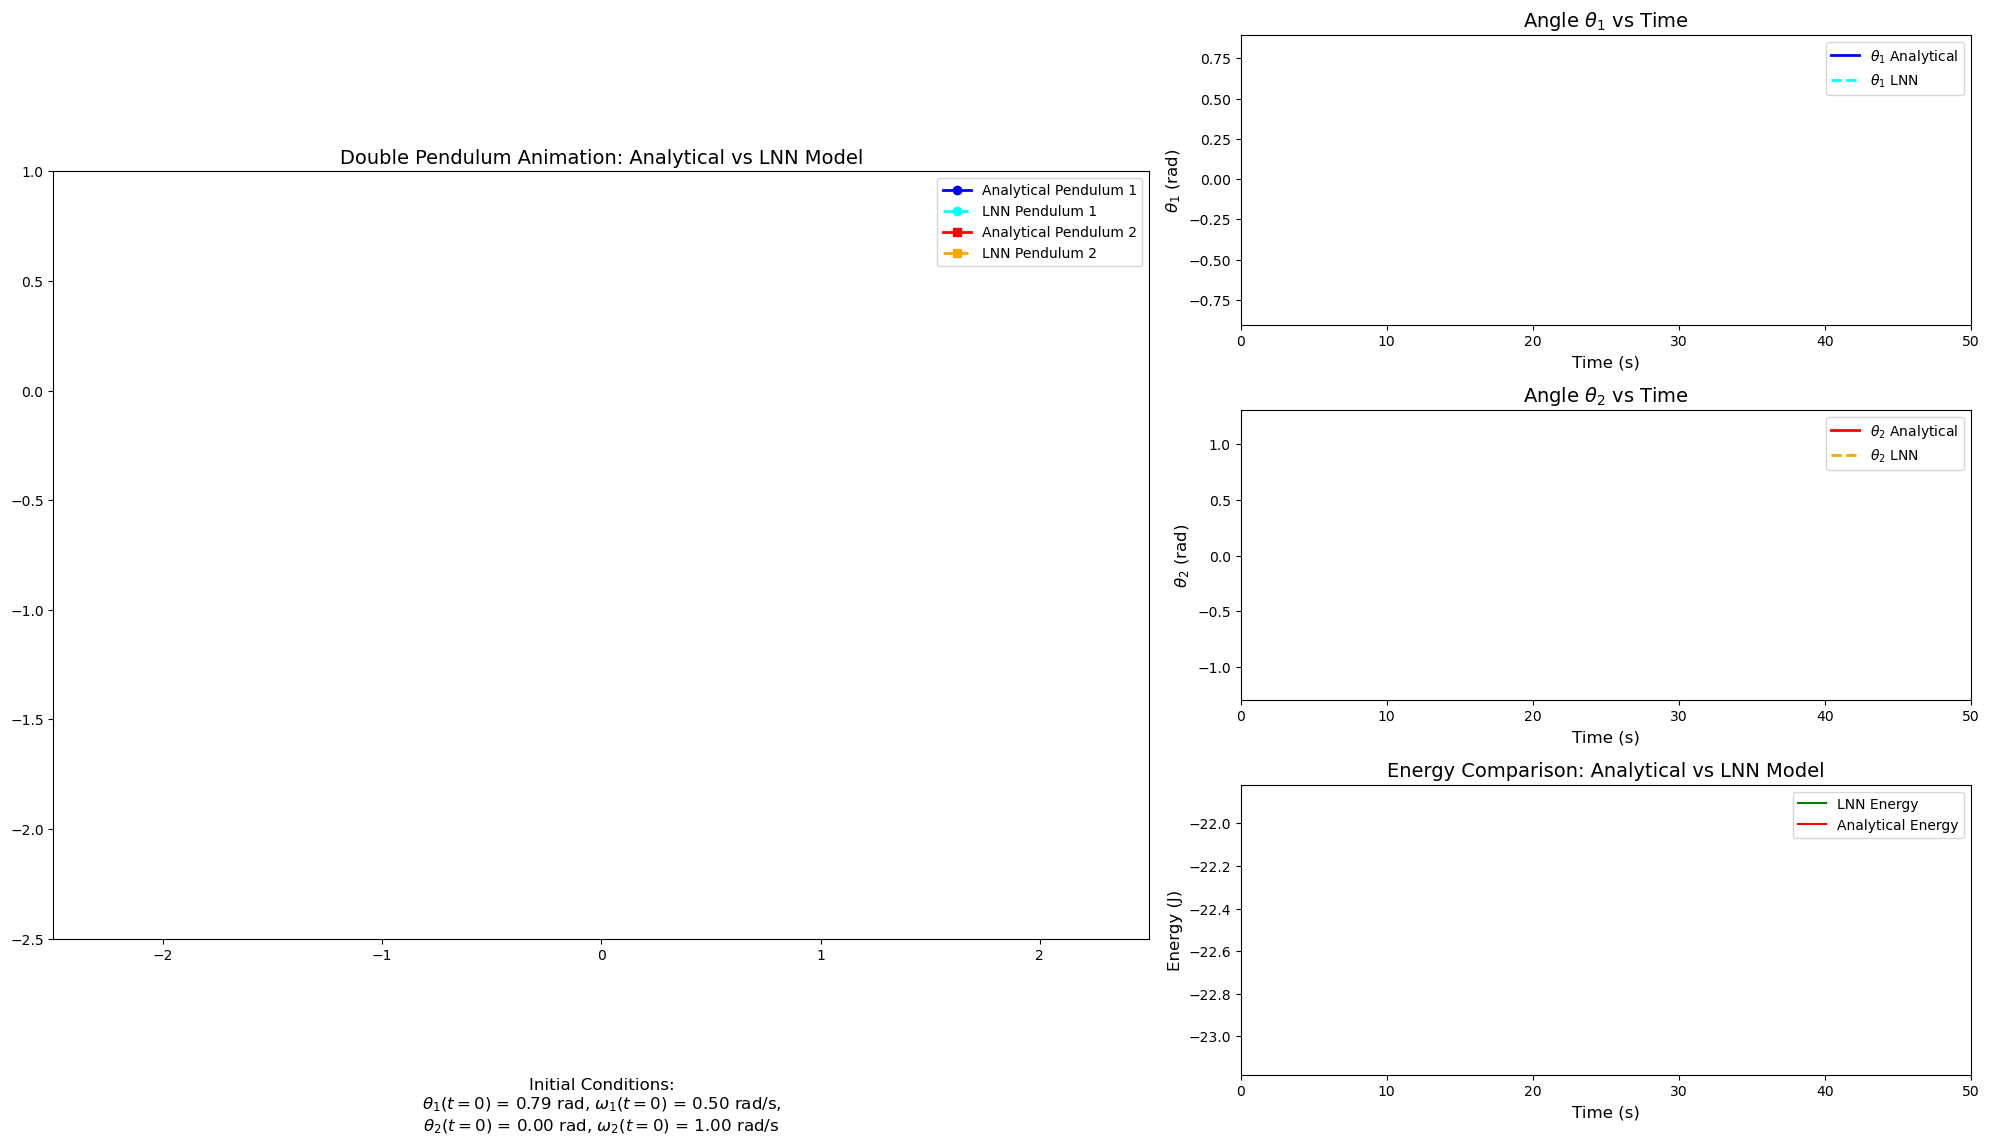

MovieWriter imagemagick unavailable; using Pillow instead.


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.gridspec as gridspec
import jax
import jax.numpy as jnp


def check_energy(th1, th2, w1, w2, m1=1, m2=1, l1=1, l2=1, g=9.8):

  T = 0.5*(m1 + m2)*l1**2*w1**2 + 0.5*m2*l2**2*w2**2 + m2*l1*l2*w1*w2*jnp.cos(th1 - th2)
  V = (m1+m2)*g*l1*jnp.cos(th1) + m2*g*l2*jnp.cos(th2)

  return T - V

# =====================
# Extract Angles and Angular Velocities
# =====================
theta_1, theta_2 = x_analy[:, 0], x_analy[:, 1]
theta_1_LNN, theta_2_LNN = x1_model[:, 0], x1_model[:, 1]
omega1, omega2 = x_analy[:, 2], x_analy[:, 3]
omega1_LNN, omega2_LNN = x1_model[:, 2], x1_model[:, 3]

# =====================
# Calculate Energy
# =====================
x_analy = jax.device_get(solve_analytical(x1, t2))

energy_analytique = check_energy(x_analy[:,0], x_analy[:,1], x_analy[:,2], x_analy[:,3])
energy_pred_LNN = check_energy(x1_model[:,0], x1_model[:,1], x1_model[:,2], x1_model[:,3])

# =====================
# Time Parameters
# =====================
dt = t2[1] - t2[0]
t_max = np.max(t2)

# =====================
# Pendulum Parameters
# =====================
L1, L2 = 1.0, 1.0  # Lengths of the pendulums

# =====================
# Origin Position
# =====================
x_origin, y_origin = 0, 0  # Fixed origin position

# =====================
# Calculate Mass Positions (Analytical)
# =====================
# Pendulum 1 Analytical
x1_analytic_pos = x_origin + L1 * np.sin(theta_1)
y1_analytic_pos = y_origin - L1 * np.cos(theta_1)

# Pendulum 2 Analytical (attached to pendulum 1)
x2_analytic_pos = x1_analytic_pos + L2 * np.sin(theta_2)
y2_analytic_pos = y1_analytic_pos - L2 * np.cos(theta_2)

# =====================
# Calculate Mass Positions (LNN)
# =====================
# Pendulum 1 LNN
x1_LNN_pos = x_origin + L1 * np.sin(theta_1_LNN)
y1_LNN_pos = y_origin - L1 * np.cos(theta_1_LNN)

# Pendulum 2 LNN (attached to pendulum 1 LNN)
x2_LNN_pos = x1_LNN_pos + L2 * np.sin(theta_2_LNN)
y2_LNN_pos = y1_LNN_pos - L2 * np.cos(theta_2_LNN)

# =====================
# Create Figure and Subplots
# =====================
fig = plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(3, 2, width_ratios=[3, 2], height_ratios=[1, 1, 1])

# ---------------------
# Subplot 1: Animation of Double Pendulum
# ---------------------
ax_anim = fig.add_subplot(gs[:, 0])  # Span all 3 rows in the first column

# Define axis limits
limit = L1 + L2 + 0.5
ax_anim.set_xlim(-limit, limit)
ax_anim.set_ylim(-limit, np.max([1, np.max(y2_LNN_pos)+0.5, np.max(y2_analytic_pos)+0.5]))

# Configure aspect and titles
ax_anim.set_aspect('equal')
ax_anim.set_title("Double Pendulum Animation: Analytical vs LNN Model", fontsize=14)
ax_anim.grid(False)

# Initialize lines for analytical and LNN pendulums
line1_analytic, = ax_anim.plot([], [], 'o-', lw=2, color='blue', label='Analytical Pendulum 1')
line1_LNN, = ax_anim.plot([], [], 'o--', lw=2, color='cyan', label='LNN Pendulum 1')
line2_analytic, = ax_anim.plot([], [], 's-', lw=2, color='red', label='Analytical Pendulum 2')
line2_LNN, = ax_anim.plot([], [], 's--', lw=2, color='orange', label='LNN Pendulum 2')
time_text_anim = ax_anim.text(0.05, 0.95, '', transform=ax_anim.transAxes,
                               fontsize=12, verticalalignment='top')

ax_anim.legend(frameon=True, loc='upper right')

# ---------------------
# Subplot 2: theta1 vs Time
# ---------------------
ax_theta1 = fig.add_subplot(gs[0, 1])
ax_theta1.set_xlim(0, t_max)
theta1_min = min(theta_1.min(), theta_1_LNN.min()) - 0.1
theta1_max = max(theta_1.max(), theta_1_LNN.max()) + 0.1
ax_theta1.set_ylim(theta1_min, theta1_max)
ax_theta1.set_title(r"Angle $\theta_1$ vs Time", fontsize=14)
ax_theta1.set_xlabel("Time (s)", fontsize=12)
ax_theta1.set_ylabel(r"$\theta_1$ (rad)", fontsize=12)
ax_theta1.grid(False)

# Initialize lines for theta1
line_theta1_analytic, = ax_theta1.plot([], [], '-', lw=2, color='blue', label=r'$\theta_1$ Analytical')
line_theta1_LNN, = ax_theta1.plot([], [], '--', lw=2, color='cyan', label=r'$\theta_1$ LNN')

ax_theta1.legend(frameon=True, loc='upper right')

# ---------------------
# Subplot 3: theta2 vs Time
# ---------------------
ax_theta2 = fig.add_subplot(gs[1, 1])
ax_theta2.set_xlim(0, t_max)
theta2_min = min(theta_2.min(), theta_2_LNN.min()) - 0.1
theta2_max = max(theta_2.max(), theta_2_LNN.max()) + 0.1
ax_theta2.set_ylim(theta2_min, theta2_max)
ax_theta2.set_title(r"Angle $\theta_2$ vs Time", fontsize=14)
ax_theta2.set_xlabel("Time (s)", fontsize=12)
ax_theta2.set_ylabel(r"$\theta_2$ (rad)", fontsize=12)
ax_theta2.grid(False)

# Initialize lines for theta2
line_theta2_analytic, = ax_theta2.plot([], [], '-', lw=2, color='red', label=r'$\theta_2$ Analytical')
line_theta2_LNN, = ax_theta2.plot([], [], '--', lw=2, color='orange', label=r'$\theta_2$ LNN')

ax_theta2.legend(frameon=True, loc='upper right')

# ---------------------
# Subplot 4: Energy vs Time
# ---------------------
ax_energy = fig.add_subplot(gs[2, 1])
ax_energy.set_xlim(0, t_max)
energy_min = min(energy_analytique.min(), energy_pred_LNN.min()) - 0.5
energy_max = max(energy_analytique.max(), energy_pred_LNN.max()) + 0.5
ax_energy.set_ylim(energy_min, energy_max)
ax_energy.set_title("Energy Comparison: Analytical vs LNN Model", fontsize=14)
ax_energy.set_xlabel("Time (s)", fontsize=12)
ax_energy.set_ylabel("Energy (J)", fontsize=12)
ax_energy.grid(False)

# Initialize lines for energy
line_energy_LNN, = ax_energy.plot([], [], 'g-', label="LNN Energy")
line_energy_analytic, = ax_energy.plot([], [], 'r-', label="Analytical Energy")

ax_energy.legend(frameon=True, loc='upper right')

# =====================
# Initialize Data Lists
# =====================
theta1_analytic_data = []
theta1_LNN_data = []
theta2_analytic_data = []
theta2_LNN_data = []
energy_analytic_data = []
energy_LNN_data = []
time_data = []

# =====================
# Add Initial Conditions Text
# =====================
# Retrieve initial conditions
theta1_analytic_init = theta_1[0]
omega1_init = omega1[0]
theta2_analytic_init = theta_2[0]
omega2_init = omega2[0]

theta1_LNN_init = theta_1_LNN[0]
omega1_LNN_init = omega1_LNN[0]
theta2_LNN_init = theta_2_LNN[0]
omega2_LNN_init = omega2_LNN[0]

# Create formatted strings with LaTeX formatting
initial_conditions = (
    f"Initial Conditions:\n"
    f"$\\theta_1(t=0)$ = {theta1_analytic_init:.2f} rad, "
    f"$\\omega_1(t=0)$ = {omega1_init:.2f} rad/s,\n"
    f"$\\theta_2(t=0)$ = {theta2_analytic_init:.2f} rad, "
    f"$\\omega_2(t=0)$ = {omega2_init:.2f} rad/s"
)

# Add text below the animation subplot
ax_anim.text(0.5, -0.25, initial_conditions,
             transform=ax_anim.transAxes, ha='center', fontsize=12)

"""
# Add text below the theta1 subplot
ax_theta1.text(0.5, -0.25, initial_conditions,
              transform=ax_theta1.transAxes, ha='center', fontsize=12)

# Add text below the theta2 subplot
ax_theta2.text(0.5, -0.25, initial_conditions,
              transform=ax_theta2.transAxes, ha='center', fontsize=12)

# Add text below the energy subplot (optional)
ax_energy.text(0.5, -0.25, initial_conditions,
              transform=ax_energy.transAxes, ha='center', fontsize=12)

"""              

# =====================
# Animation Initialization
# =====================
def init_anim():
    # Initialize pendulum 1 Analytical
    line1_analytic.set_data([], [])
    
    # Initialize pendulum 1 LNN
    line1_LNN.set_data([], [])
    
    # Initialize pendulum 2 Analytical
    line2_analytic.set_data([], [])
    
    # Initialize pendulum 2 LNN
    line2_LNN.set_data([], [])
    
    # Initialize energy lines
    line_energy_LNN.set_data([], [])
    line_energy_analytic.set_data([], [])
    
    # Initialize angle plots
    line_theta1_analytic.set_data([], [])
    line_theta1_LNN.set_data([], [])
    line_theta2_analytic.set_data([], [])
    line_theta2_LNN.set_data([], [])
    
    # Initialize time text
    time_text_anim.set_text('')
    
    return (line1_analytic, line1_LNN, line2_analytic, line2_LNN,
            line_theta1_analytic, line_theta1_LNN,
            line_theta2_analytic, line_theta2_LNN,
            line_energy_LNN, line_energy_analytic,
            time_text_anim)

# =====================
# Animation Update Function
# =====================
def update_anim(frame):
    # Update Pendulum 1 Analytical
    x1_analytic = [x_origin, x1_analytic_pos[frame]]
    y1_analytic = [y_origin, y1_analytic_pos[frame]]
    line1_analytic.set_data(x1_analytic, y1_analytic)
    
    # Update Pendulum 1 LNN
    x1_LNN = [x_origin, x1_LNN_pos[frame]]
    y1_LNN = [y_origin, y1_LNN_pos[frame]]
    line1_LNN.set_data(x1_LNN, y1_LNN)
    
    # Update Pendulum 2 Analytical
    x2_analytic = [x1_analytic_pos[frame], x2_analytic_pos[frame]]
    y2_analytic = [y1_analytic_pos[frame], y2_analytic_pos[frame]]
    line2_analytic.set_data(x2_analytic, y2_analytic)
    
    # Update Pendulum 2 LNN
    x2_LNN = [x1_LNN_pos[frame], x2_LNN_pos[frame]]
    y2_LNN = [y1_LNN_pos[frame], y2_LNN_pos[frame]]
    line2_LNN.set_data(x2_LNN, y2_LNN)
    
    # Update Time Text
    current_time = frame * dt
    time_text_anim.set_text(f'Time = {current_time:.2f} s')
    
    # Update Angle Plots
    time_data.append(current_time)
    theta1_analytic_data.append(theta_1[frame])
    theta1_LNN_data.append(theta_1_LNN[frame])
    theta2_analytic_data.append(theta_2[frame])
    theta2_LNN_data.append(theta_2_LNN[frame])
    
    line_theta1_analytic.set_data(time_data, theta1_analytic_data)
    line_theta1_LNN.set_data(time_data, theta1_LNN_data)
    line_theta2_analytic.set_data(time_data, theta2_analytic_data)
    line_theta2_LNN.set_data(time_data, theta2_LNN_data)
    
    # Update Energy Plot
    energy_analytic_data.append(energy_analytique[frame])
    energy_LNN_data.append(energy_pred_LNN[frame])
    
    line_energy_analytic.set_data(time_data, energy_analytic_data)
    line_energy_LNN.set_data(time_data, energy_LNN_data)
    
    return (line1_analytic, line1_LNN, line2_analytic, line2_LNN,
            line_theta1_analytic, line_theta1_LNN,
            line_theta2_analytic, line_theta2_LNN,
            line_energy_LNN, line_energy_analytic,
            time_text_anim)

# =====================
# Create and Display Animation
# =====================
ani = FuncAnimation(fig, update_anim, frames=len(t2),
                    init_func=init_anim, blit=False, interval=dt*1000, repeat=True)

# Adjust layout to accommodate the initial conditions text
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space at the bottom for text

# Display the animation
plt.show()

# =====================
# Optional: Save the Animation
# =====================
# To save the animation as an MP4 file, ensure that FFmpeg is installed
# Uncomment the following lines to save the animation

# ani.save('double_pendulum_LNN.mp4', writer='ffmpeg', fps=30)

# To save the animation as a GIF, ensure that ImageMagick is installed
# Uncomment the following line to save the animation as GIF

ani.save('double_pendulum_energy_extended.gif', writer='imagemagick', fps=30)

### Affichage des vitesses angulaires

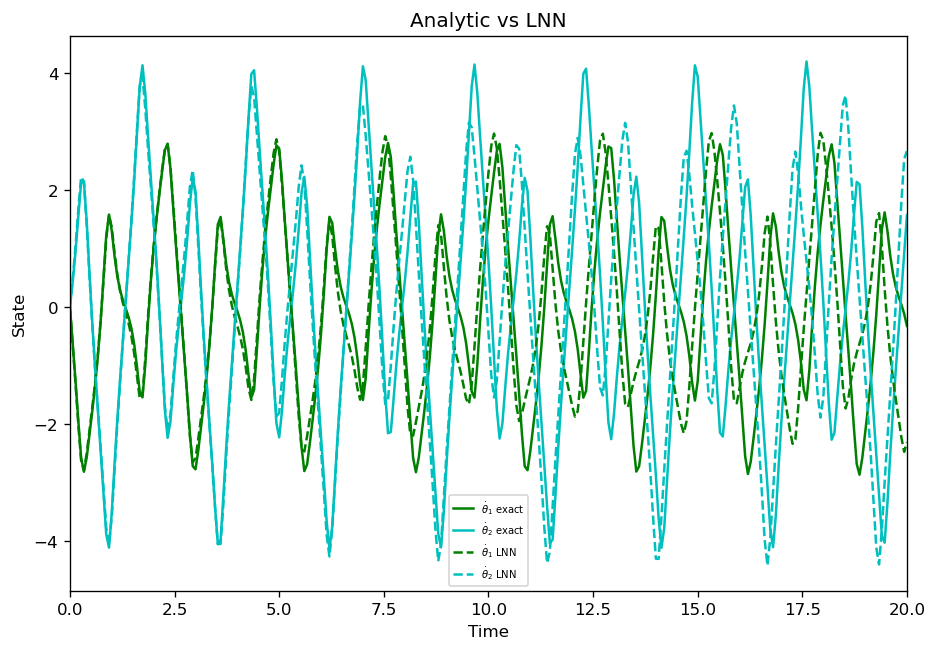

In [40]:
plt.figure(figsize=[9,6], dpi=120) ; plt.xlim(0, 20)
plt.title("Analytic vs LNN")
plt.xlabel("Time") ; plt.ylabel("State")
plt.plot(t2, x1_analytical[:, 2], 'g-', label=r'$\dot \theta_1$ exact')
plt.plot(t2, x1_analytical[:, 3], 'c-', label=r'$\dot \theta_2$ exact')
plt.plot(t2, x1_model[:, 2], 'g--', label=r'$\dot \theta_1$ LNN')
plt.plot(t2, x1_model[:, 3], 'c--', label=r'$\dot \theta_2$ LNN')
plt.legend(fontsize=6)

### Comparaison NN & LNN

Conditions Initiales Personnalisées: [0.7853982 0.        0.        0.       ]
Conditions Initiales Normalisées: [[ 0.8677545  -0.02016153  0.          0.        ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Prédiction Normalisée Shape: (1, 301, 4)
Prédiction Inversée Shape: (1, 301, 4)
Trajectoire Réelle Shape: (301, 4)


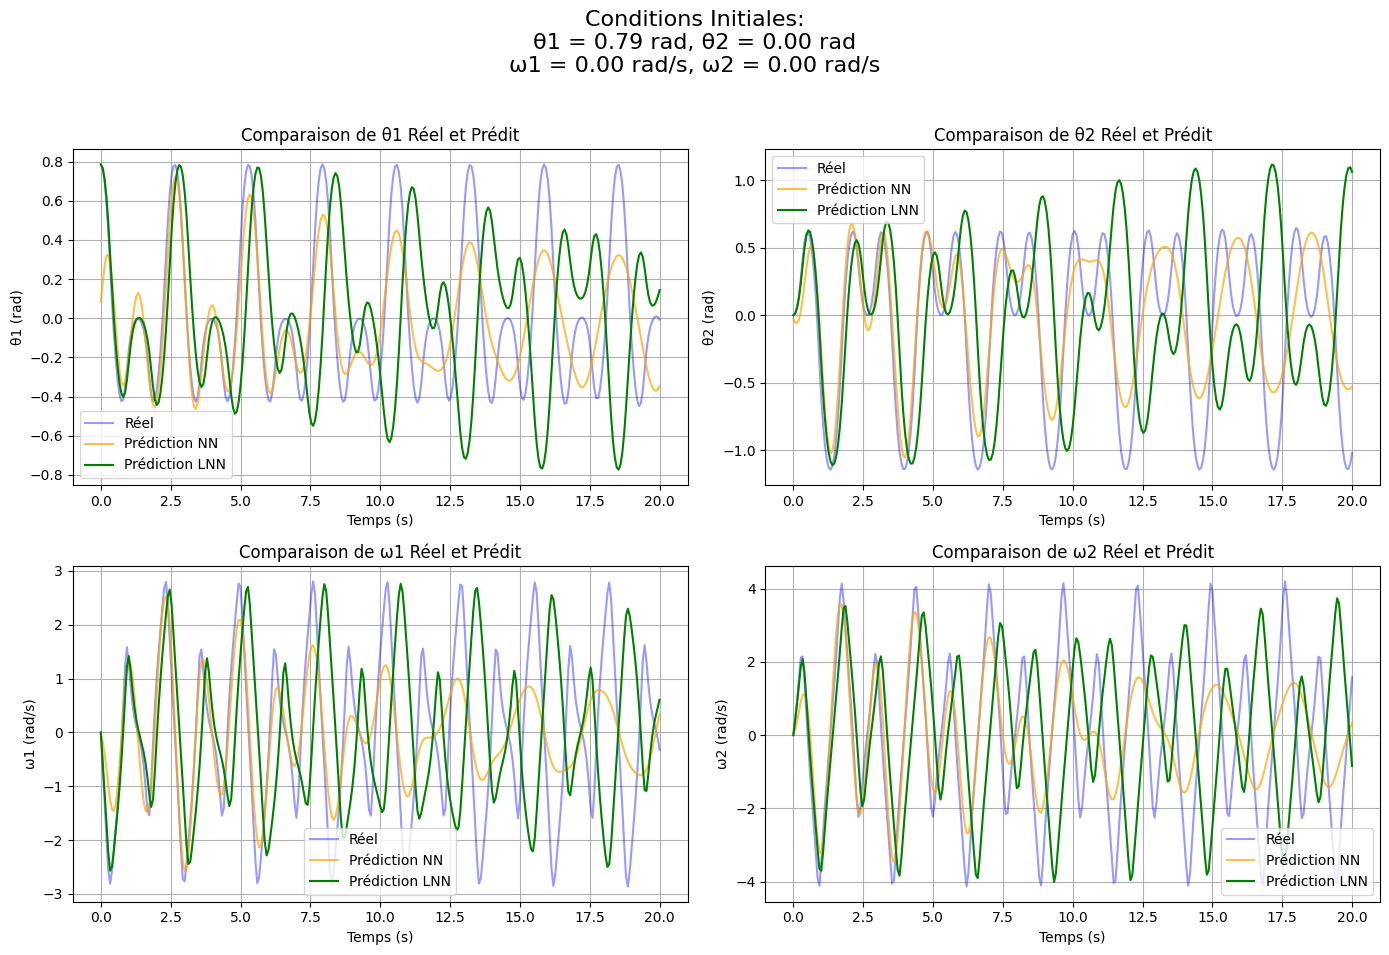

In [ ]:
# 1. Définir vos propres conditions initiales
custom_initial = np.array([np.pi/4, 0, 0, 0], dtype=np.float32)
print("Conditions Initiales Personnalisées:", custom_initial)

# 2. Normaliser les conditions initiales
custom_initial_scaled = scaler_X.transform(custom_initial.reshape(1, -1))  # Forme: (1, 4)
print("Conditions Initiales Normalisées:", custom_initial_scaled)

# 3. Faire la prédiction
predicted_scaled = model.predict(custom_initial_scaled)  # Forme: (1, 301, 4)
print("Prédiction Normalisée Shape:", predicted_scaled.shape)

# 4. Inverser la normalisation
predicted_inv = scaler_y.inverse_transform(predicted_scaled.reshape(-1, 4)).reshape(predicted_scaled.shape)  # Forme: (1, 301, 4)
print("Prédiction Inversée Shape:", predicted_inv.shape)

# 5. Visualiser la trajectoire prédite
duree = np.linspace(0, 20, num=301)  # Assurez-vous que 'duree' est défini

trajectory_pred = predicted_inv[0]  # Forme: (301, 4)

# 6. (Optionnel) Comparer avec une trajectoire réelle
# Générer la trajectoire réelle
actual_trajectory = generate_trajectory(custom_initial)  # Forme: (301, 4)
print("Trajectoire Réelle Shape:", actual_trajectory.shape)

plt.figure(figsize=(14, 10))

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(duree, actual_trajectory[:, i], label='Réel', color='blue', alpha=0.4)
    plt.plot(duree, trajectory_pred[:, i], label='Prédiction NN', color='orange', alpha=0.7)
    plt.plot(t2, x1_model[:, i], 'g-', label=r'Prédiction LNN')
    plt.legend()
    plt.xlabel('Temps (s)')
    plt.ylabel(f'{labels[i]} ({units[i]})')
    plt.title(f'Comparaison de {labels[i]} Réel et Prédit')
    plt.grid(True)

# Ajouter les conditions initiales comme une annotation globale
plt.suptitle(
    f'Conditions Initiales:\n'
    f'θ1 = {custom_initial[0]:.2f} rad, θ2 = {custom_initial[1]:.2f} rad\n'
    f'ω1 = {custom_initial[2]:.2f} rad/s, ω2 = {custom_initial[3]:.2f} rad/s',
    fontsize=16,
    y=0.95
)

plt.tight_layout(rect=[0, 0, 1, 0.93])  # Ajuster l'espace pour la super-titre
plt.show()

### Comparaison de l'énergie pour les différents modèles.

Il y. a surement un problème --> Checker les conditions initiales

In [ ]:
energy_analytique = check_energy(actual_trajectory[:,0], actual_trajectory[:,1], actual_trajectory[:,2], actual_trajectory[:,3])
energy_pred_NN = check_energy(trajectory_pred[:,0], trajectory_pred[:,1], trajectory_pred[:,2], trajectory_pred[:,3])
energy_pred_LNN = check_energy(x1_model[:,0], x1_model[:,1], x1_model[:,2], x1_model[:,3])
plt.plot(duree, energy_analytique, label='Energie Analytique')
plt.plot(duree, energy_pred_NN, label='Energie Baseline NN')
plt.plot(t2, energy_pred_LNN, 'g-', label=r'Energie LNN')

print("LNN Conditions initiales >>", x1_model[0,:])
print("NN Conditions initiales >>", trajectory_pred[0,:])

plt.xlabel(r'Temps (s)')
plt.ylabel(r'Energie (J)')
plt.legend()

NameError: name 'actual_trajectory' is not defined

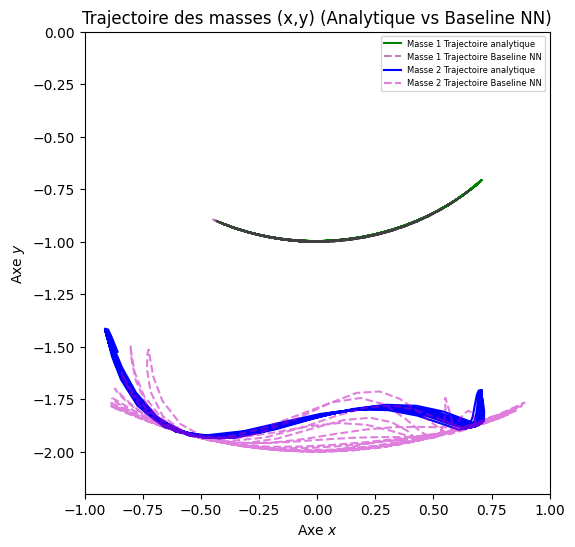

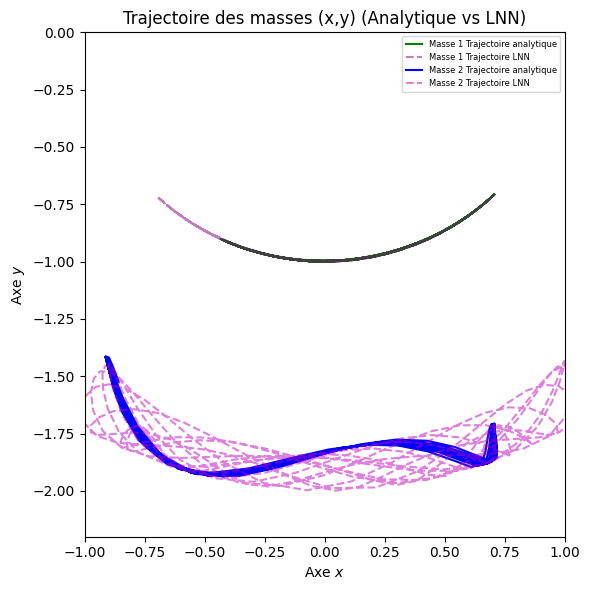

In [ ]:
#Assuming l1 = l2 = 1
l1, l2 = 1, 1

# Calculate Cartesian coordinates for each pendulum mass
# Analytical case
x1_cartesian_analytical = l1 * np.sin(x1_analytical[:, 0])
y1_cartesian_analytical = -l1 * np.cos(x1_analytical[:, 0])
x2_cartesian_analytical = x1_cartesian_analytical + l2 * np.sin(x1_analytical[:, 1])
y2_cartesian_analytical = y1_cartesian_analytical - l2 * np.cos(x1_analytical[:, 1])

# Perturbed case
x1_cartesian_perturbed = l1 * np.sin(x1_perturbed[:, 0])
y1_cartesian_perturbed = -l1 * np.cos(x1_perturbed[:, 0])
x2_cartesian_perturbed = x1_cartesian_perturbed + l2 * np.sin(x1_perturbed[:, 1])
y2_cartesian_perturbed = y1_cartesian_perturbed - l2 * np.cos(x1_perturbed[:, 1])

# Model predictions case
x1_cartesian_model_NN = l1 * np.sin(trajectory_pred[:,0])
y1_cartesian_model_NN = -l1 * np.cos(trajectory_pred[:,0])
x2_cartesian_model_NN = x1_cartesian_model_NN + l2 * np.sin(trajectory_pred[:,1])
y2_cartesian_model_NN = y1_cartesian_model_NN - l2 * np.cos(trajectory_pred[:,1])


# Fourth plot: trajectory of both masses using model predictions
plt.figure(figsize = [6,6])
plt.title("Trajectoire des masses (x,y) (Analytique vs Baseline NN)")
plt.ylim(-2.2, 0)
plt.xlim(-1, 1)
plt.xlabel(r"Axe $x$")
plt.ylabel(r"Axe $y$")
# Mass 1 trajectories (Model)
plt.plot(x1_cartesian_analytical, y1_cartesian_analytical, 'g-', label='Masse 1 Trajectoire analytique')
plt.plot(x1_cartesian_model_NN, y1_cartesian_model_NN, '--', color='purple', alpha=0.5, label='Masse 1 Trajectoire Baseline NN')
# Mass 2 trajectories (Model)
plt.plot(x2_cartesian_analytical, y2_cartesian_analytical, 'b-', label='Masse 2 Trajectoire analytique')
plt.plot(x2_cartesian_model_NN, y2_cartesian_model_NN, 'm--', alpha=0.5, label='Masse 2 Trajectoire Baseline NN')
plt.legend(fontsize=6)


# Fourth plot: trajectory of both masses using model predictions
plt.figure(figsize = [6,6])
plt.title("Trajectoire des masses (x,y) (Analytique vs LNN)")
plt.ylim(-2.2, 0)
plt.xlim(-1, 1)
plt.xlabel(r"Axe $x$")
plt.ylabel(r"Axe $y$")
# Mass 1 trajectories (Model)
plt.plot(x1_cartesian_analytical, y1_cartesian_analytical, 'g-', label='Masse 1 Trajectoire analytique')
plt.plot(x1_cartesian_model, y1_cartesian_model, '--', color='purple', alpha=0.5, label='Masse 1 Trajectoire LNN')
# Mass 2 trajectories (Model)
plt.plot(x2_cartesian_analytical, y2_cartesian_analytical, 'b-', label='Masse 2 Trajectoire analytique')
plt.plot(x2_cartesian_model, y2_cartesian_model, 'm--', alpha=0.5, label='Masse 2 Trajectoire LNN')
plt.legend(fontsize=6)

plt.legend(fontsize=6)

plt.tight_layout()
plt.show()


### Fonction d'erreur (Mathis)

In [ ]:
from scipy.integrate import trapezoid

def error(x1model, x2model, x1analytical, x2analytical, t = t2 ):
  Error1 = np.sqrt(trapezoid((x1model - x1analytical)**2, t))/(np.sqrt(trapezoid((x1analytical)**2, t)) + np.sqrt(trapezoid((x1model)**2, t)))
  Error2 = np.sqrt(trapezoid((x2model - x2analytical)**2, t))/(np.sqrt(trapezoid((x2analytical)**2, t)) + np.sqrt(trapezoid((x2model)**2, t)))
  return (Error1 + Error2)/2


Pour le LNN

In [ ]:
erreur_LNN = error(x1_model[:,0], x1_model[:,1], x1_analytical[:,0], x1_analytical[:,1])
print(erreur_LNN)

erreur_NN = error(trajectory_pred[:,0], trajectory_pred[:,1], x1_analytical[:,0], x1_analytical[:,1])
print(erreur_NN)

  Error1 = np.sqrt(trapz((x1model - x1analytical)**2, t))/(np.sqrt(trapz((x1analytical)**2, t)) + np.sqrt(trapz((x1model)**2, t)))

  Error2 = np.sqrt(trapz((x2model - x2analytical)**2, t))/(np.sqrt(trapz((x2analytical)**2, t)) + np.sqrt(trapz((x2model)**2, t)))



0.7787603688230782
0.2958906831271082


## **Step 9: Make videos of the system**

We'll use these to get an intuitive sense of how well our model has learned the dynamics

### i) First, we need to define functions for plotting the pendulum
Sam used [this scipy tutorial](https://scipython.com/blog/the-double-pendulum/) and Stephan Hoyer's [wave equation demo for Jax on TPU](https://colab.research.google.com/github/google/jax/blob/master/cloud_tpu_colabs/Wave_Equation.ipynb) to write the following code.

In [ ]:
def make_plot(i, cart_coords, l1, l2, max_trail=30, trail_segments=20, r = 0.05):
    # Plot and save an image of the double pendulum configuration for time step i.
    plt.cla()

    x1, y1, x2, y2 = cart_coords
    ax.plot([0, x1[i], x2[i]], [0, y1[i], y2[i]], lw=2, c='k') # rods
    c0 = Circle((0, 0), r/2, fc='k', zorder=10) # anchor point
    c1 = Circle((x1[i], y1[i]), r, fc='b', ec='b', zorder=10) # mass 1
    c2 = Circle((x2[i], y2[i]), r, fc='r', ec='r', zorder=10) # mass 2
    ax.add_patch(c0)
    ax.add_patch(c1)
    ax.add_patch(c2)

    # plot the pendulum trail (ns = number of segments)
    s = max_trail // trail_segments
    for j in range(trail_segments):
        imin = i - (trail_segments-j)*s
        if imin < 0: continue
        imax = imin + s + 1
        alpha = (j/trail_segments)**2 # fade the trail into alpha
        ax.plot(x2[imin:imax], y2[imin:imax], c='r', solid_capstyle='butt',
                lw=2, alpha=alpha)

    # Center the image on the fixed anchor point. Make axes equal.
    ax.set_xlim(-l1-l2-r, l1+l2+r)
    ax.set_ylim(-l1-l2-r, l1+l2+r)
    ax.set_aspect('equal', adjustable='box')
    plt.axis('off')
    # plt.savefig('./frames/_img{:04d}.png'.format(i//di), dpi=72)

def radial2cartesian(t1, t2, l1, l2):
  # Convert from radial to Cartesian coordinates.
  x1 = l1 * np.sin(t1)
  y1 = -l1 * np.cos(t1)
  x2 = x1 + l2 * np.sin(t2)
  y2 = y1 - l2 * np.cos(t2)
  return x1, y1, x2, y2

def fig2image(fig):
  fig.canvas.draw()
  data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
  image = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
  return image

### ii) Next, we'll make a movie of the pendulum's analytic dynamics

0/300
1/300 2/300 3/300 4/300 5/300 6/300 7/300 8/300 9/300 10/300 11/300 12/300 13/300 14/300 15/300 16/300 17/300 18/300 19/300 20/300
21/300 22/300 23/300 24/300 25/300 26/300 27/300 28/300 29/300 30/300 31/300 32/300 33/300 34/300 35/300 36/300 37/300 38/300 39/300 40/300
41/300 42/300 43/300 44/300 45/300 46/300 47/300 48/300 49/300 50/300 51/300 52/300 53/300 54/300 55/300 56/300 57/300 58/300 59/300 60/300
61/300 62/300 63/300 64/300 65/300 66/300 67/300 68/300 69/300 70/300 71/300 72/300 73/300 74/300 75/300 76/300 77/300 78/300 79/300 80/300
81/300 82/300 83/300 84/300 85/300 86/300 87/300 88/300 89/300 90/300 91/300 92/300 93/300 94/300 95/300 96/300 97/300 98/300 99/300 100/300
101/300 102/300 103/300 104/300 105/300 106/300 107/300 108/300 109/300 110/300 111/300 112/300 113/300 114/300 115/300 116/300 117/300 118/300 119/300 120/300
121/300 122/300 123/300 124/300 125/300 126/300 127/300 128/300 129/300 130/300 131/300 132/300 133/300 134/300 135/300 136/300 137/300 138/30

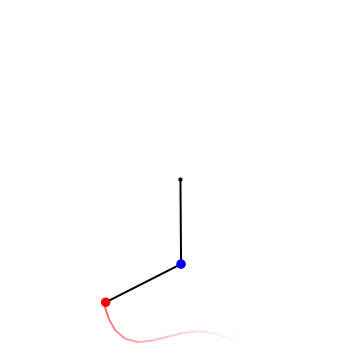

In [ ]:
L1, L2 = 1, 1
theta1, theta2 = x1_analytical[:, 0], x1_analytical[:, 1]
cart_coords = radial2cartesian(theta1, theta2, L1, L2)

fig = plt.figure(figsize=(8.3333, 6.25), dpi=72)
ax = fig.add_subplot(111)

import warnings
warnings.filterwarnings("ignore")

images = []
di = 1
N = 300
for i in range(0, N, di):
  print("{}/{}".format(i // di, N // di), end='\n' if i//di%20==0 else ' ')
  make_plot(i, cart_coords, L1, L2)
  images.append( fig2image(fig) )

In [ ]:
def save_movie(images, path, duration=100, loop=0, **kwargs):
  images[0].save(path, save_all=True, append_images=images[1:],
                 duration=duration, loop=loop, **kwargs)

# Save GIF.
PIL_images = [Image.fromarray(im, mode='RGB') for im in images]
save_movie(PIL_images, 'double_pend_anal.gif')
# The movie sometimes takes a second before showing up in the file system.
import time; time.sleep(1)

# Download animation.
from google.colab import files
files.download('double_pend_anal.gif')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import importlib
importlib.reload(proglog)
print("True (analytical) dynamics of the double pendulum:")
proglog.default_bar_logger = partial(proglog.default_bar_logger, None)
ImageSequenceClip(images, fps=25).ipython_display()

True (analytical) dynamics of the double pendulum:


### ii) Now let's visualize the LNN's dynamics

0/300
1/300 2/300 3/300 4/300 5/300 6/300 7/300 8/300 9/300 10/300 11/300 12/300 13/300 14/300 15/300 16/300 17/300 18/300 19/300 20/300
21/300 22/300 23/300 24/300 25/300 26/300 27/300 28/300 29/300 30/300 31/300 32/300 33/300 34/300 35/300 36/300 37/300 38/300 39/300 40/300
41/300 42/300 43/300 44/300 45/300 46/300 47/300 48/300 49/300 50/300 51/300 52/300 53/300 54/300 55/300 56/300 57/300 58/300 59/300 60/300
61/300 62/300 63/300 64/300 65/300 66/300 67/300 68/300 69/300 70/300 71/300 72/300 73/300 74/300 75/300 76/300 77/300 78/300 79/300 80/300
81/300 82/300 83/300 84/300 85/300 86/300 87/300 88/300 89/300 90/300 91/300 92/300 93/300 94/300 95/300 96/300 97/300 98/300 99/300 100/300
101/300 102/300 103/300 104/300 105/300 106/300 107/300 108/300 109/300 110/300 111/300 112/300 113/300 114/300 115/300 116/300 117/300 118/300 119/300 120/300
121/300 122/300 123/300 124/300 125/300 126/300 127/300 128/300 129/300 130/300 131/300 132/300 133/300 134/300 135/300 136/300 137/300 138/30

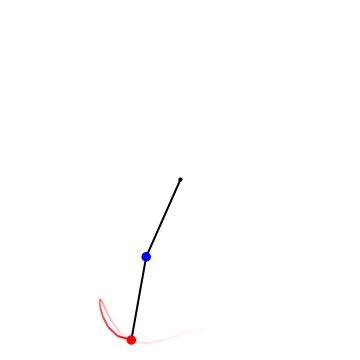

In [ ]:
L1, L2 = 1, 1
theta1, theta2 = x1_model[:, 0], x1_model[:, 1]
cart_coords = radial2cartesian(theta1, theta2, L1, L2)

fig = plt.figure(figsize=(8.3333, 6.25), dpi=72)
ax = fig.add_subplot(111)

images = []
di = 1
N = 300
for i in range(0, N, di):
  print("{}/{}".format(i // di, N // di), end='\n' if i//di%20==0 else ' ')
  make_plot(i, cart_coords, L1, L2)
  images.append( fig2image(fig) )

In [ ]:
import importlib
importlib.reload(proglog)
print("LNN-predicted dynamics of the double pendulum:")
proglog.default_bar_logger = partial(proglog.default_bar_logger, None)
ImageSequenceClip(images, fps=25).ipython_display()

LNN-predicted dynamics of the double pendulum:


In [ ]:
def save_movie(images, path, duration=100, loop=0, **kwargs):
  images[0].save(path, save_all=True, append_images=images[1:],
                 duration=duration, loop=loop, **kwargs)

# Save GIF.
PIL_images = [Image.fromarray(im, mode='RGB') for im in images]
save_movie(PIL_images, 'double_pend_lnn.gif')
# The movie sometimes takes a second before showing up in the file system.
import time; time.sleep(1)

# Download animation.
from google.colab import files
files.download('double_pend_lnn.gif')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Step 10: Conclusions**
We just learned a double pendulum Lagrangian from data! Correction: we learned the double pendulum Lagrangian for a specific case where both arm lengths and both bob masses were 1. Furthermore, all of our train and test data was sampled from a single energy level of the double pendulum. But this is a good first step. These results are exciting because they are better than what an HNN or even a baseline neural ODE could achieve (we also made these comparisons in separate notebooks).

For the purposes of our paper, we learned a model across different energy levels and added better network initializations, training techniques, and more. We also learned the Lagrangians of other physical systems including a 1D wave equation and a particle in a relativistic field. In theory, this approach should generalize well to other systems and to non-canonical coordinate systems such as the latent vector of a VAE.

$\quad$

Thanks for checking out our LNN tutorial, and please contact us with any questions.

In [48]:
# choose an initial state
x1 = np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32) # Condition de train

#x1 = np.array([5*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32)

t2 = np.linspace(0, 20, num=301)
%time x1_analytical = jax.device_get(solve_analytical(x1, t2))
noise_coeff_3 = 1e-3
%time x1_perturbed = jax.device_get(solve_analytical(x1 + noise_coeff_3 * noise, t2))
%time x1_model = jax.device_get(solve_lagrangian(learned_lagrangian(params), x1, t=t2))

xt = jax.device_get(jax.vmap(f_analytical)(x1_analytical))
xt_model = jax.device_get(jax.vmap(partial(equation_of_motion, learned_lagrangian(params))))(x1_model)


#x1_autograd = jax.device_get(solve_autograd(x1_model, t2))

CPU times: user 33.5 ms, sys: 6.44 ms, total: 39.9 ms
Wall time: 53.5 ms
CPU times: user 33.8 ms, sys: 262 μs, total: 34.1 ms
Wall time: 34.2 ms
CPU times: user 1.94 s, sys: 115 ms, total: 2.06 s
Wall time: 2.1 s


<>:24: SyntaxWarning: invalid escape sequence '\e'
<>:24: SyntaxWarning: invalid escape sequence '\e'
/var/folders/_5/450_dsxx7pqfnwb2rs5wpndm0000gn/T/ipykernel_43465/2405719801.py:24: SyntaxWarning: invalid escape sequence '\e'
  """


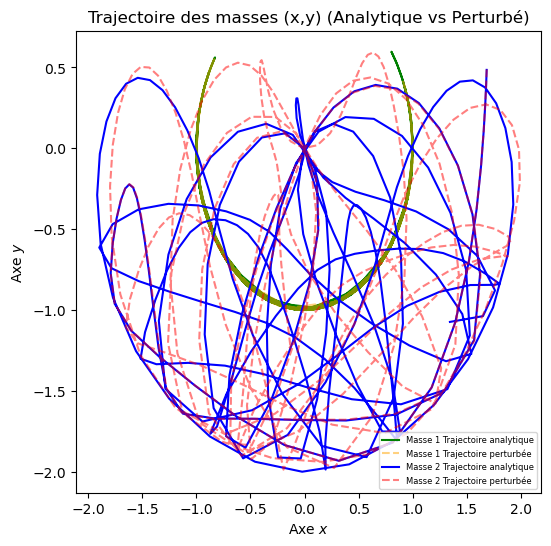

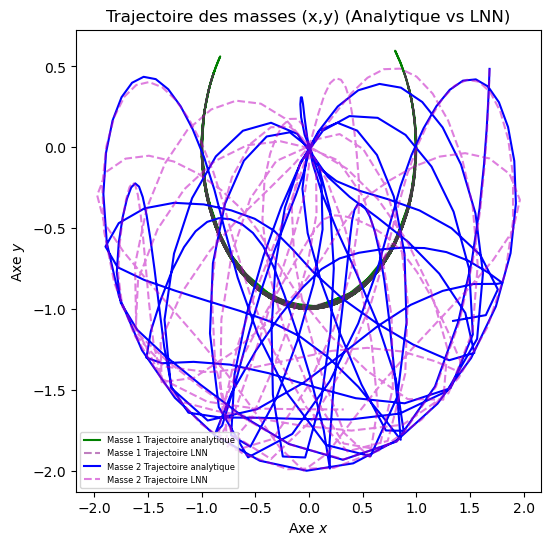

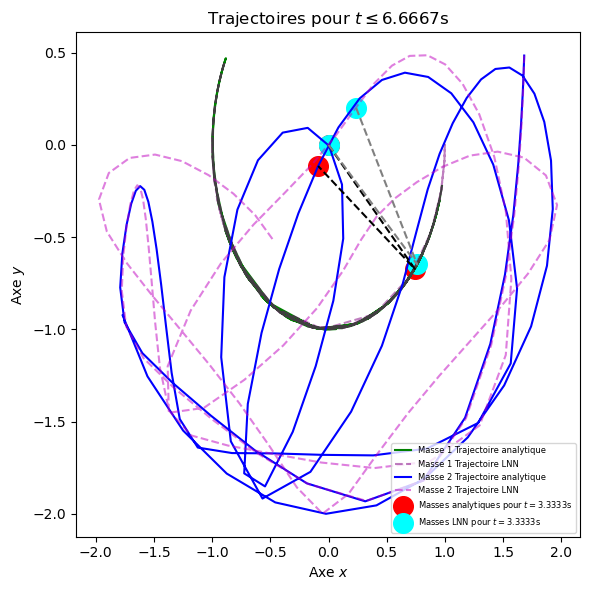

In [49]:
#Assuming l1 = l2 = 1
l1, l2 = 1, 1

# Calculate Cartesian coordinates for each pendulum mass
# Analytical case
x1_cartesian_analytical = l1 * np.sin(x1_analytical[:, 0])
y1_cartesian_analytical = -l1 * np.cos(x1_analytical[:, 0])
x2_cartesian_analytical = x1_cartesian_analytical + l2 * np.sin(x1_analytical[:, 1])
y2_cartesian_analytical = y1_cartesian_analytical - l2 * np.cos(x1_analytical[:, 1])

# Perturbed case
x1_cartesian_perturbed = l1 * np.sin(x1_perturbed[:, 0])
y1_cartesian_perturbed = -l1 * np.cos(x1_perturbed[:, 0])
x2_cartesian_perturbed = x1_cartesian_perturbed + l2 * np.sin(x1_perturbed[:, 1])
y2_cartesian_perturbed = y1_cartesian_perturbed - l2 * np.cos(x1_perturbed[:, 1])

# Model predictions case
x1_cartesian_model = l1 * np.sin(x1_model[:, 0])
y1_cartesian_model = -l1 * np.cos(x1_model[:, 0])
x2_cartesian_model = x1_cartesian_model + l2 * np.sin(x1_model[:, 1])
y2_cartesian_model = y1_cartesian_model - l2 * np.cos(x1_model[:, 1])


"""
# First plot: angles vs time
plt.figure(figsize = [9,6])
plt.title("Analytic vs Perturbed ($\epsilon$={})".format(noise_coeff_3))
plt.xlabel("Time")
plt.ylabel("State")
plt.plot(t2, x1_analytical[:, 0], 'g-', label=r'$\theta_1$ exact')
plt.plot(t2, x1_analytical[:, 1], 'c-', label=r'$\theta_2$ exact')
plt.plot(t2, x1_perturbed[:, 0], 'g--', label=r'$\theta_1$ perturbed')
plt.plot(t2, x1_perturbed[:, 1], 'c--', label=r'$\theta_2$ perturbed')
plt.legend(fontsize=6)

# Second plot: analytic vs model
plt.figure(figsize = [9,6])
plt.title("Analytic vs LNN")
plt.xlabel("Time")
plt.ylabel("State")
plt.plot(t2, x1_analytical[:, 0], 'g-', label=r'$\theta_1$ exact')
plt.plot(t2, x1_analytical[:, 1], 'c-', label=r'$\theta_2$ exact')
plt.plot(t2, x1_model[:, 0], 'g--', label=r'$\theta_1$ LNN')
plt.plot(t2, x1_model[:, 1], 'c--', label=r'$\theta_2$ LNN')
plt.legend(fontsize=6)
"""

# Third plot: trajectory of both masses (analytical and perturbed)
plt.figure(figsize = [6,6])
plt.title("Trajectoire des masses (x,y) (Analytique vs Perturbé)")
plt.xlabel(r"Axe $x$")
plt.ylabel(r"Axe $y$")
#plt.ylim(-2.2, 0)
#plt.xlim(-1, 1)
# Mass 1 trajectories
plt.plot(x1_cartesian_analytical, y1_cartesian_analytical, 'g-', label='Masse 1 Trajectoire analytique')
plt.plot(x1_cartesian_perturbed, y1_cartesian_perturbed, '--', color='orange', alpha=0.5, label='Masse 1 Trajectoire perturbée')
# Mass 2 trajectories
plt.plot(x2_cartesian_analytical, y2_cartesian_analytical, 'b-', label='Masse 2 Trajectoire analytique')
plt.plot(x2_cartesian_perturbed, y2_cartesian_perturbed, 'r--', alpha=0.5, label='Masse 2 Trajectoire perturbée')
plt.legend(fontsize=6)

# Fourth plot: trajectory of both masses using model predictions
plt.figure(figsize = [6,6])
plt.title("Trajectoire des masses (x,y) (Analytique vs LNN)")
#plt.ylim(-2.2, 0)
#plt.xlim(-1, 1)
plt.xlabel(r"Axe $x$")
plt.ylabel(r"Axe $y$")
# Mass 1 trajectories (Model)
plt.plot(x1_cartesian_analytical, y1_cartesian_analytical, 'g-', label='Masse 1 Trajectoire analytique')
plt.plot(x1_cartesian_model, y1_cartesian_model, '--', color='purple', alpha=0.5, label='Masse 1 Trajectoire LNN')
# Mass 2 trajectories (Model)
plt.plot(x2_cartesian_analytical, y2_cartesian_analytical, 'b-', label='Masse 2 Trajectoire analytique')
plt.plot(x2_cartesian_model, y2_cartesian_model, 'm--', alpha=0.5, label='Masse 2 Trajectoire LNN')
plt.legend(fontsize=6)


# Fifth plot: trajectory of both masses using model predictions
plt.figure(figsize = [6,6])
plt.title(r"Trajectoires pour $t\leq$"+str(round(t2[100], 4))+"s")
#plt.ylim(-2.2, 0)
#plt.xlim(-1, 1)
plt.xlabel(r"Axe $x$")
plt.ylabel(r"Axe $y$")
# Mass 1 trajectories (Model)
plt.plot(x1_cartesian_analytical[:100], y1_cartesian_analytical[:100], 'g-', label='Masse 1 Trajectoire analytique')
plt.plot(x1_cartesian_model[:100], y1_cartesian_model[:100], '--', color='purple', alpha=0.5, label='Masse 1 Trajectoire LNN')
# Mass 2 trajectories (Model)
plt.plot(x2_cartesian_analytical[:100], y2_cartesian_analytical[:100], 'b-', label='Masse 2 Trajectoire analytique')
plt.plot(x2_cartesian_model[:100], y2_cartesian_model[:100], 'm--', alpha=0.5, label='Masse 2 Trajectoire LNN')

#Représentation d'un pendule
plt.plot([0, x1_cartesian_analytical[50], x2_cartesian_analytical[50]], [0, y1_cartesian_analytical[50], y2_cartesian_analytical[50]], '--', color='black')
plt.scatter([0, x1_cartesian_analytical[50], x2_cartesian_analytical[50]], [0, y1_cartesian_analytical[50], y2_cartesian_analytical[50]], color='red', s=200, label='Masses analytiques pour $t=$'+str(round(t2[50], 4))+'s')

plt.plot([0, x1_cartesian_model[50], x2_cartesian_model[50]], [0, y1_cartesian_model[50], y2_cartesian_model[50]], '--', color='gray')
plt.scatter([0, x1_cartesian_model[50], x2_cartesian_model[50]], [0, y1_cartesian_model[50], y2_cartesian_model[50]], color='cyan', s=200, label='Masses LNN pour $t=$'+str(round(t2[50], 4))+'s')

plt.legend(fontsize=6)

plt.legend(fontsize=6)

plt.tight_layout()
plt.show()


On va recréer la figure de l'article.

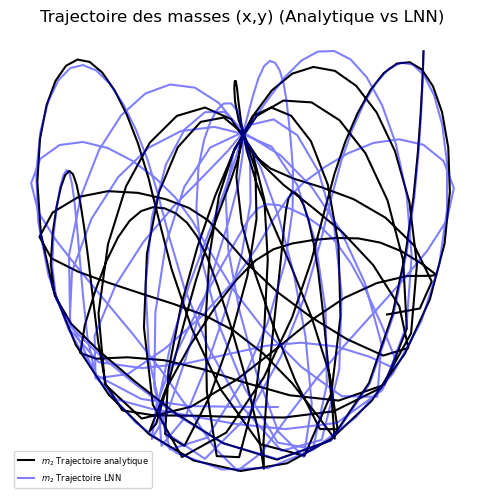

In [50]:
plt.figure(figsize = [6,6])
plt.title("Trajectoire des masses (x,y) (Analytique vs LNN)")
#plt.ylim(-2.2, 0)
#plt.xlim(-1, 1)
plt.axis("off")
plt.xlabel(r"Axe $x$")
plt.ylabel(r"Axe $y$")
# Mass 1 trajectories (Model)
#plt.plot(x1_cartesian_analytical, y1_cartesian_analytical, 'g-', label='Masse 1 Trajectoire analytique')
#plt.plot(x1_cartesian_model, y1_cartesian_model, '--', color='purple', alpha=0.5, label='Masse 1 Trajectoire LNN')
# Mass 2 trajectories (Model)
plt.plot(x2_cartesian_analytical, y2_cartesian_analytical, 'k-', label='$m_2$ Trajectoire analytique')
plt.plot(x2_cartesian_model, y2_cartesian_model, 'b-', alpha=0.5, label='$m_2$ Trajectoire LNN')
plt.legend(fontsize=6)

/var/folders/_5/450_dsxx7pqfnwb2rs5wpndm0000gn/T/ipykernel_43465/3801737954.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=6)


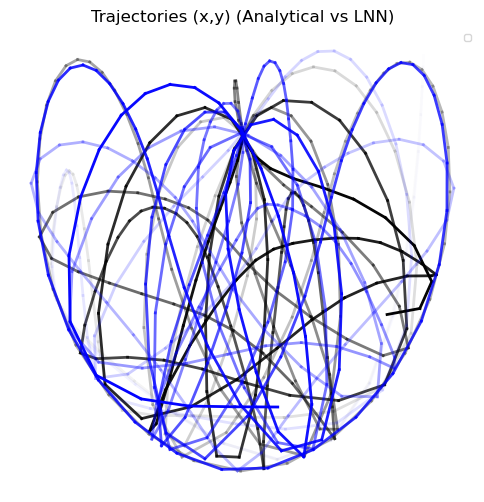

In [56]:
# Création de la figure
plt.figure(figsize=[6, 6])
plt.title("Trajectories (x,y) (Analytical vs LNN)")
plt.axis("off")
plt.xlabel(r"Axe $x$")
plt.ylabel(r"Axe $y$")

# Tracer avec opacité variable
def plot_with_fading_opacity(x, y, color, label):
    for i in range(len(x) - 1):
        plt.plot(x[i:i+2], y[i:i+2], color=color, alpha=i / len(x), lw=2)

# Mass 2 trajectories (Analytique)
plot_with_fading_opacity(x2_cartesian_analytical, y2_cartesian_analytical, 'k', label='$m_2$ Trajectoire analytique')
# Mass 2 trajectories (Model)
plot_with_fading_opacity(x2_cartesian_model, y2_cartesian_model, 'b', label='$m_2$ Trajectoire LNN')

# Ajout de la légende
plt.legend(fontsize=6)
plt.savefig("ComparisonTraj.pdf", bbox_inches='tight')

/var/folders/_5/450_dsxx7pqfnwb2rs5wpndm0000gn/T/ipykernel_43465/2930503196.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=6)


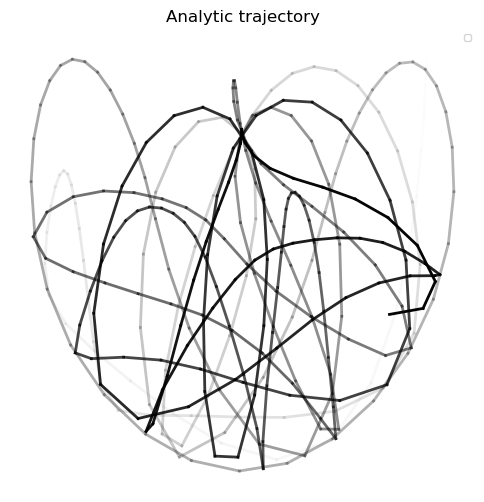

In [52]:
# Création de la figure
plt.figure(figsize=[6, 6])
plt.title("Analytic trajectory")
plt.axis("off")
plt.xlabel(r"Axe $x$")
plt.ylabel(r"Axe $y$")

# Tracer avec opacité variable
def plot_with_fading_opacity(x, y, color, label):
    for i in range(len(x) - 1):
        plt.plot(x[i:i+2], y[i:i+2], color=color, alpha=i / len(x), lw=2)

# Mass 2 trajectories (Analytique)
plot_with_fading_opacity(x2_cartesian_analytical, y2_cartesian_analytical, 'k', label='$m_2$ Analytical trajectory')
# Mass 2 trajectories (Model)
#plot_with_fading_opacity(x2_cartesian_model, y2_cartesian_model, 'b', label='$m_2$ Trajectoire LNN')

# Ajout de la légende
plt.legend(fontsize=6)
plt.savefig("AnalyticTraj.pdf", bbox_inches="tight")

/var/folders/_5/450_dsxx7pqfnwb2rs5wpndm0000gn/T/ipykernel_43465/2691650209.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=6)


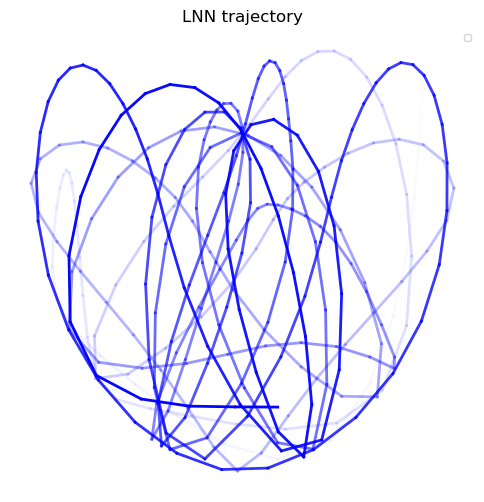

In [53]:
# Création de la figure
plt.figure(figsize=[6, 6])
plt.title("LNN trajectory")
plt.axis("off")
plt.xlabel(r"Axe $x$")
plt.ylabel(r"Axe $y$")

# Tracer avec opacité variable
def plot_with_fading_opacity(x, y, color, label):
    for i in range(len(x) - 1):
        plt.plot(x[i:i+2], y[i:i+2], color=color, alpha=i / len(x), lw=2)

# Mass 2 trajectories (Analytique)
#plot_with_fading_opacity(x2_cartesian_analytical, y2_cartesian_analytical, 'k', label='$m_2$ Analytical trajectory')
# Mass 2 trajectories (Model)
plot_with_fading_opacity(x2_cartesian_model, y2_cartesian_model, 'b', label='$m_2$ Trajectoire LNN')

# Ajout de la légende
plt.legend(fontsize=6)
plt.savefig("LNNTraj.pdf", bbox_inches="tight")

In [21]:
x1 = np.array([np.pi/4, np.pi/2, 0, 0], dtype=np.float32) # Condition pour laquelle ça marche vraiment très bien.

t3 = np.linspace(0, 40, num=401)

x1_analytical = jax.device_get(solve_analytical(x1, t3))
x1_model = jax.device_get(solve_lagrangian(learned_lagrangian(params), x1, t=t3))

In [22]:
np.save('t3.npy', t3)
np.save('x1_model.npy', x1_model)